## Welcome to my MLP Project Notebook!
This notebook is the final version of the project.

*Disclaimers*
- Some GridSearchCVs are changed to contain only one option or very few options. This done so that the notebook can be run in a reasonable amount of time. Previously tested parameters wil be written in Markdown blocks like this one.
- Pipelines were avoided as it clashs with the style of the notebook. However they do have application if this notebook is converted to a basic python program.
- Main comparison is done based on kaggle score ALONE! I did not do any other overt model vs model comparisons as I do not have access to the test data labels. So for consistency, I will only compare models based on their kaggle score.
- Basic model evaluation is done by the RMSE and a basic label vs prediction plot. This is done to get a general idea of how the model is performing. 

The notebook's general structure is as follows:
1. Create copy of data for the model.
1. Test run the model with default parameters.
1. Run the model with tuned parameters from GridSearchCV.
1. Make a submission to kaggle and check score to determine if the model is worth trying to refine further, or if it should be scrapped.

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
# train = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')
# train_og = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')
# test = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')
# sample_submission = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv')

In [3]:
train = pd.read_csv('train.csv')
train_og = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample.csv.csv')

# Exploratory Data Analysis
First i want to see what the data looks like. What are the datatypes, value range etc. After that find any null values and decide how to manage them and also deal with outliers.

In [4]:
train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [5]:
train.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,175000.000000,168923.000000,175000.000000,168923.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,168923.000000,168923.000000
mean,0.728377,1.357678,5.145930,1.518307,132.710349,132.701429,1.932143,6.127497,0.646816,0.979689,29.633901,2.246971,0.158825
std,0.445606,0.891283,394.971052,6.514678,76.148799,76.192493,1.948497,4.610834,2.328274,0.198775,25.425206,0.819216,0.511968
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-7.500000,0.000079,-29.300000,-1.000000,-576.750000,-2.500000,-1.750000
25%,0.000000,1.000000,1.080000,1.000000,67.000000,67.000000,0.000000,3.473321,0.000000,1.000000,16.300000,2.500000,0.000000
50%,1.000000,1.000000,1.840000,1.000000,133.000000,133.000000,1.000000,5.286217,0.000000,1.000000,21.450000,2.500000,0.000000
75%,1.000000,1.000000,3.610000,1.000000,199.000000,199.000000,2.500000,7.502746,0.000000,1.000000,31.800000,2.500000,0.000000
max,2.000000,9.000000,135182.060000,99.000000,264.000000,264.000000,11.750000,484.876151,80.000000,1.000000,587.250000,2.500000,1.750000


In [6]:
train.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type              object
extra                    float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
Airport_fee              float64
dtype: object

In [7]:
train.isnull().sum()

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
dtype: int64

We can see that store_and_fwd_flag is "object" type and it has missing values. We will see what the values are and how many of them are missing.

In [8]:
train['store_and_fwd_flag'].unique()

array(['N', nan, 'Y'], dtype=object)

We can see that it is actually a string that essentially is a boolean value of true or false. We will convert it to a boolean value.

In [9]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'N':False, 'Y':True})
train['store_and_fwd_flag'].unique()

array([False, nan, True], dtype=object)

In [10]:
storenan = train[train['store_and_fwd_flag'].isnull()]
passengernan = train[train['passenger_count'].isnull()]
storenan

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
33,1,2023-06-29 23:59:24,2023-06-29 23:10:40,NaN,2.80,NaN,NaN,216,21,Wallet,0.0,6.076642,0.00,1.0,26.93,NaN,NaN
53,1,2023-06-30 02:43:08,2023-06-30 03:44:22,NaN,18.98,NaN,NaN,72,263,Wallet,0.0,11.588252,12.75,1.0,83.24,NaN,NaN
56,1,2023-06-30 22:28:53,2023-06-30 23:33:12,NaN,1.36,NaN,NaN,116,128,Wallet,0.0,4.932110,0.00,1.0,20.69,NaN,NaN
120,0,2023-06-28 22:24:34,2023-06-28 21:57:57,NaN,1.30,NaN,NaN,183,191,Wallet,1.0,5.138688,0.00,1.0,17.25,NaN,NaN
127,0,2023-06-28 21:19:33,2023-06-28 22:56:28,NaN,0.00,NaN,NaN,8,40,Wallet,0.0,1.613173,0.00,1.0,34.11,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174925,1,2023-06-28 20:24:56,2023-06-28 20:10:58,NaN,4.46,NaN,NaN,70,228,Wallet,0.0,0.579162,0.00,1.0,51.06,NaN,NaN
174935,1,2023-06-29 09:07:59,2023-06-29 08:39:05,NaN,2.97,NaN,NaN,187,216,Wallet,0.0,5.306986,0.00,1.0,27.50,NaN,NaN
174983,1,2023-06-30 21:57:30,2023-06-30 20:55:40,NaN,4.22,NaN,NaN,193,108,Wallet,0.0,9.141031,0.00,1.0,34.19,NaN,NaN
174985,1,2023-06-30 08:12:28,2023-06-30 08:36:47,NaN,2.51,NaN,NaN,97,17,Wallet,0.0,4.679583,0.00,1.0,23.44,NaN,NaN


In [11]:
storenan.equals(passengernan)

True

Now this shows us that all rows with NaN in store_and_fwd_flag column, are rows with the other NaN values. We will put mode values in the missing values.

In [12]:
train['store_and_fwd_flag'].fillna(train['store_and_fwd_flag'].mode()[0], inplace=True)
train['passenger_count'].fillna(train['passenger_count'].mode()[0], inplace=True)
train['RatecodeID'].fillna(train['RatecodeID'].mode()[0], inplace=True)
train['congestion_surcharge'].fillna(train['congestion_surcharge'].mode()[0], inplace=True)
train['Airport_fee'].fillna(train['Airport_fee'].mode()[0], inplace=True)

In [13]:
train.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
extra                    0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
dtype: int64

The following function has been used to check if the data has any extreme changes after applying various preprocessing methods to it. It will be used again later.

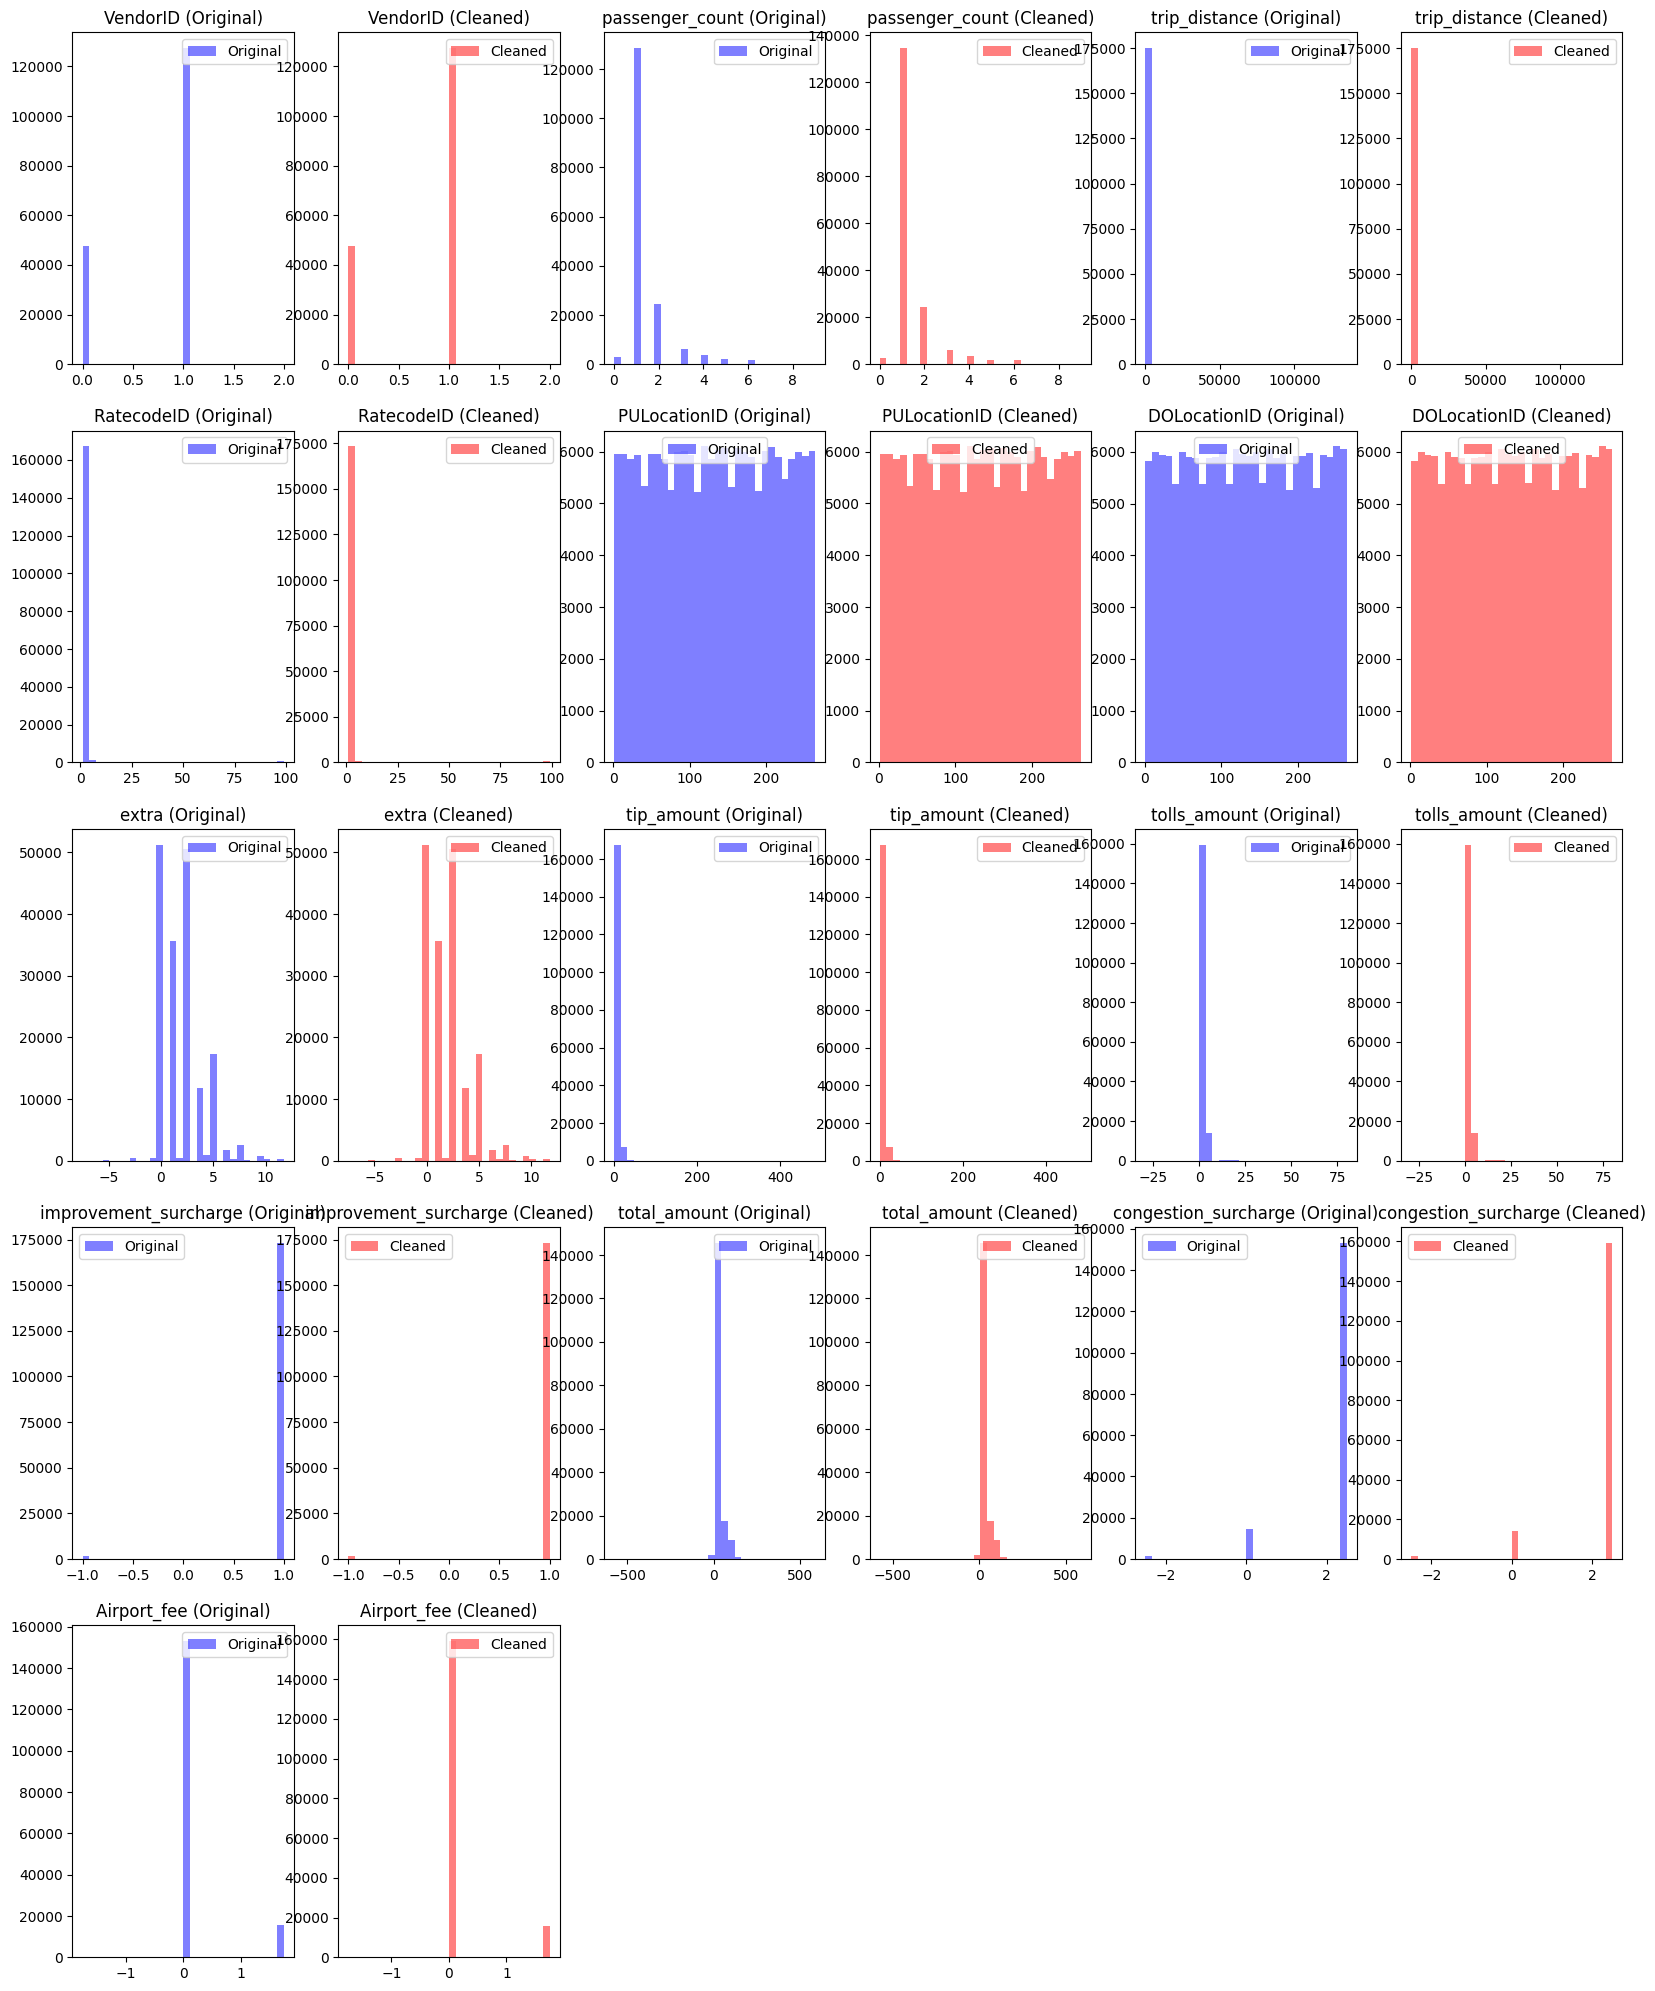

In [14]:
import matplotlib.pyplot as plt
def get_vis():
    # Get the list of numerical columns
    numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
    if 'tpep_dropoff_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_dropoff_datetime')
    if 'tpep_pickup_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_pickup_datetime')
    if 'store_and_fwd_flag_False' in numerical_cols:
        numerical_cols = numerical_cols.drop('store_and_fwd_flag_False')
    if 'store_and_fwd_flag_True' in numerical_cols:
        numerical_cols = numerical_cols.drop('store_and_fwd_flag_True')
    if 'payment_type_Cash' in numerical_cols:
        numerical_cols = numerical_cols.drop('payment_type_Cash')
    if 'payment_type_Credit Card' in numerical_cols:
        numerical_cols = numerical_cols.drop('payment_type_Credit Card')
    if 'payment_type_UPI' in numerical_cols:
        numerical_cols = numerical_cols.drop('payment_type_UPI')
    if 'payment_type_Wallet' in numerical_cols:
        numerical_cols = numerical_cols.drop('payment_type_Wallet')
    if 'payment_type_unknown' in numerical_cols:
        numerical_cols = numerical_cols.drop('payment_type_unknown')

    n_cols = 6
    n_rows = (2 * len(numerical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))

    for i, column in enumerate(numerical_cols):
        row_orig = 2 * i // n_cols
        col_orig = 2 * i % n_cols
        row_clean = (2 * i + 1) // n_cols
        col_clean = (2 * i + 1) % n_cols

        axes[row_orig, col_orig].hist(train_og[column].dropna(), bins=30, alpha=0.5, color='b', label='Original')
        axes[row_orig, col_orig].set_title(f'{column} (Original)')
        axes[row_orig, col_orig].legend()

        axes[row_clean, col_clean].hist(train[column].dropna(), bins=30, alpha=0.5, color='r', label='Cleaned')
        axes[row_clean, col_clean].set_title(f'{column} (Cleaned)')
        axes[row_clean, col_clean].legend()

    if (2 * len(numerical_cols)) % n_cols:
        for j in range((2 * len(numerical_cols)) % n_cols, n_cols):
            fig.delaxes(axes[n_rows-1, j])

    plt.show()

get_vis()

### This is visually show that the dataset isn't changed drastically after adding the mode in place of the missing values.
Now we will perform one hot encoding to the "object" type columns.

In [15]:
# we have to do encoding to these columns tpep_pickup_datetime, tpep_dropoff_datetime, store_and_fwd_flag, payment_type

# this is just for cleanliness
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])
train['tpep_dropoff_datetime'] = pd.to_datetime(train['tpep_dropoff_datetime'])

# one hot encoding
train_encoded = pd.get_dummies(train, columns=['store_and_fwd_flag', 'payment_type'])
train_encoded['tpep_pickup_datetime'] = train_encoded['tpep_pickup_datetime'].astype(np.int64) // 10**9
train_encoded['tpep_dropoff_datetime'] = train_encoded['tpep_dropoff_datetime'].astype(np.int64) // 10**9


train = train_encoded
train_encoded.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,...,total_amount,congestion_surcharge,Airport_fee,store_and_fwd_flag_False,store_and_fwd_flag_True,payment_type_Cash,payment_type_Credit Card,payment_type_UPI,payment_type_Wallet,payment_type_unknown
0,1,1687972821,1687970085,1.0,2.14,1.0,120,9,2.5,7.165589,...,20.64,2.5,0.0,True,False,False,True,False,False,False
1,0,1688079901,1688076095,1.0,2.70,1.0,15,215,3.5,6.067401,...,25.55,2.5,0.0,True,False,False,True,False,False,False
2,1,1688120371,1688123590,1.0,1.15,1.0,167,223,0.0,4.111547,...,17.64,2.5,0.0,True,False,False,True,False,False,False
3,0,1688044989,1688048401,1.0,0.40,1.0,128,239,2.5,6.411079,...,12.80,2.5,0.0,True,False,False,True,False,False,False
4,1,1688076212,1688077342,3.0,1.10,1.0,203,52,1.0,4.769377,...,18.00,2.5,0.0,True,False,False,True,False,False,False


In [16]:
bool_cols = ['store_and_fwd_flag_False', 'store_and_fwd_flag_True', 'payment_type_Cash', 'payment_type_Credit Card', 'payment_type_UPI', 'payment_type_Wallet', 'payment_type_unknown']
train[bool_cols] = train[bool_cols].astype(int)

#### Now that we have the data in a format that we can use, we will start to explore the data and removing outliers.

In [17]:
train.dtypes

VendorID                      int64
tpep_pickup_datetime          int64
tpep_dropoff_datetime         int64
passenger_count             float64
trip_distance               float64
RatecodeID                  float64
PULocationID                  int64
DOLocationID                  int64
extra                       float64
tip_amount                  float64
tolls_amount                float64
improvement_surcharge       float64
total_amount                float64
congestion_surcharge        float64
Airport_fee                 float64
store_and_fwd_flag_False      int32
store_and_fwd_flag_True       int32
payment_type_Cash             int32
payment_type_Credit Card      int32
payment_type_UPI              int32
payment_type_Wallet           int32
payment_type_unknown          int32
dtype: object

Now we will make box plots to visualize outliers
###### We are not visualizing the categorical values.

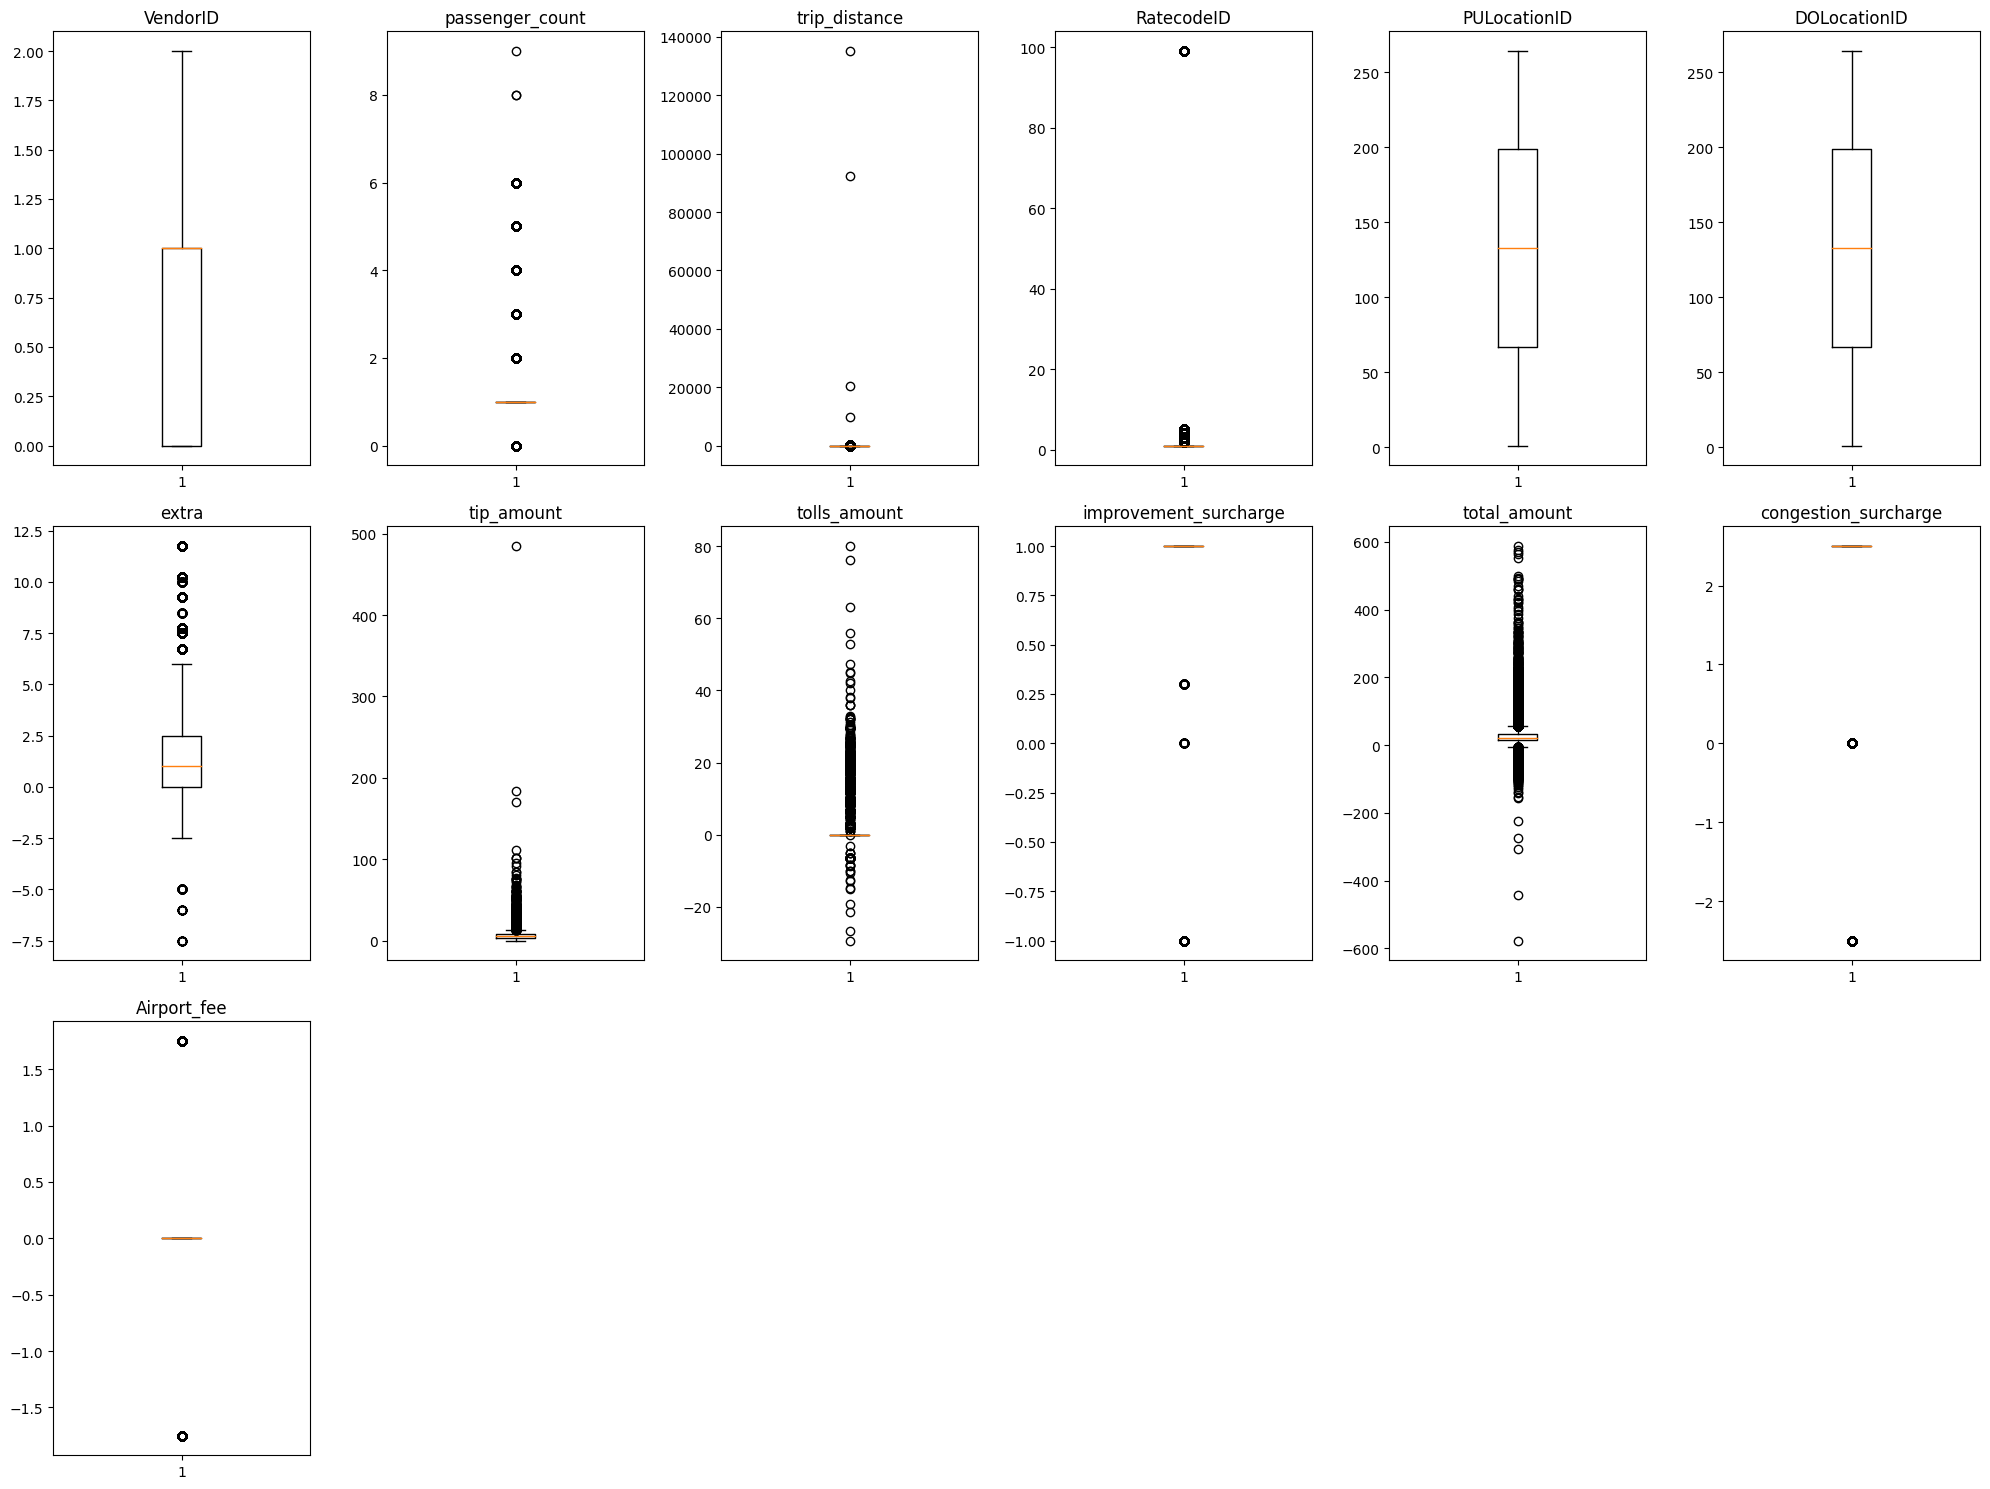

In [18]:
# box plots
def get_vis_box():
    numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
    if 'tpep_dropoff_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_dropoff_datetime')
    if 'tpep_pickup_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_pickup_datetime')
    n_cols = 6
    n_rows = len(numerical_cols) // n_cols
    n_rows += len(numerical_cols) % n_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))

    for i, column in enumerate(numerical_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].boxplot(train[column].dropna())
        axes[row, col].set_title(f'{column}')

    if len(numerical_cols) % n_cols:
        for j in range(len(numerical_cols) % n_cols, n_cols):
            fig.delaxes(axes[n_rows-1, j])

    plt.tight_layout()
    plt.show()

get_vis_box()

### Now we will go column by column
Vendor ID is not something we should thing about as it is an ID.
Let's see passenger_count more carefully.

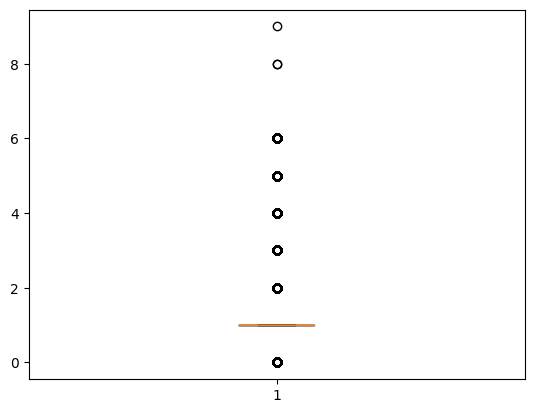

passenger_count
1.0    134611
2.0     24316
3.0      6018
4.0      3668
0.0      2818
5.0      1970
6.0      1596
8.0         2
9.0         1
Name: count, dtype: int64

In [19]:
plt.boxplot(train['passenger_count'])
plt.show()
train['passenger_count'].value_counts()

We can see that only 8.0 and 9.0 are the outliers here. The rest have significant amount of data. We will remove the outliers.

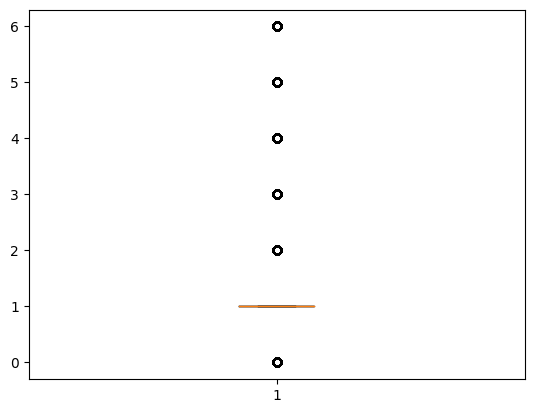

passenger_count
1.0    134611
2.0     24316
3.0      6018
4.0      3668
0.0      2818
5.0      1970
6.0      1596
Name: count, dtype: int64

In [20]:
train.drop(train[train['passenger_count'] > 7].index, inplace=True)
plt.boxplot(train['passenger_count'])
plt.show()
train['passenger_count'].value_counts()

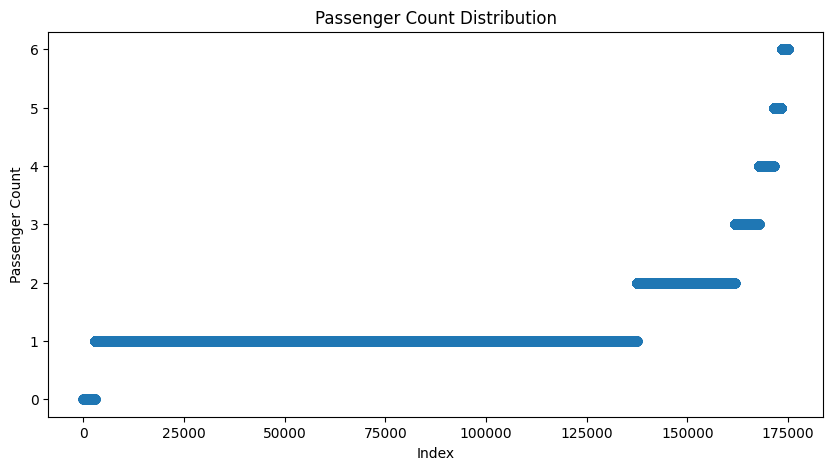

In [21]:
plt.figure(figsize=(10, 5))
plt.scatter(range(train.shape[0]), np.sort(train['passenger_count'].values))
plt.xlabel('Index')
plt.ylabel('Passenger Count')
plt.title('Passenger Count Distribution')
plt.show()

#### While the box plot makes it look like there are a lot of outliers, the scatter plot shows that it is not the case.
Now we repeat for all the other columns.
- trip_distance
- RatecodeID
- extra
- tip_amount
- tolls_amount
- improvement_surcharge
- total_amount
- congestion_surcharge

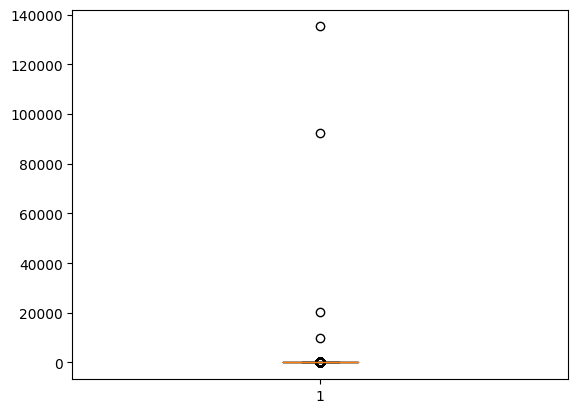

trip_distance
0.00     2632
1.00     2431
0.90     2383
1.20     2363
1.10     2297
         ... 
31.42       1
26.80       1
27.53       1
13.29       1
15.17       1
Name: count, Length: 2929, dtype: int64

In [22]:
plt.boxplot(train['trip_distance'])
plt.show()
train['trip_distance'].value_counts()

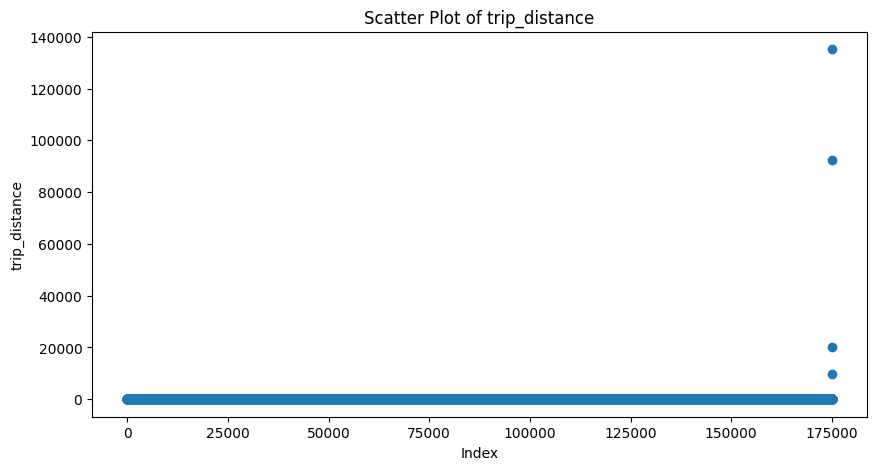

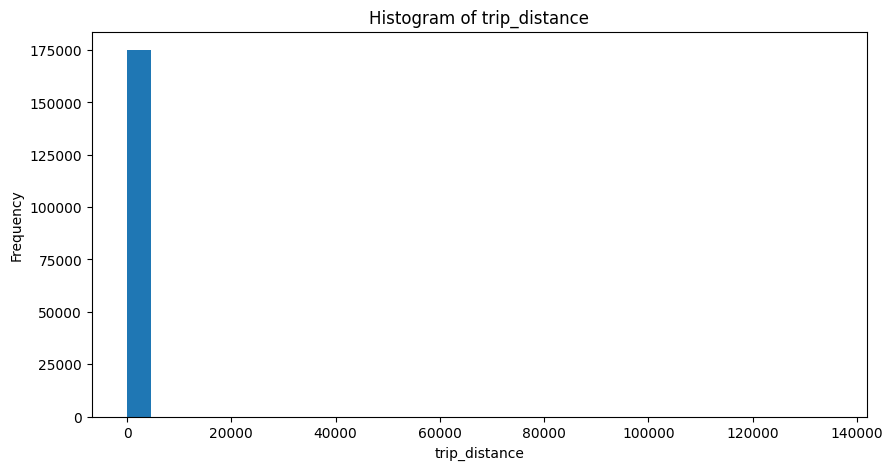

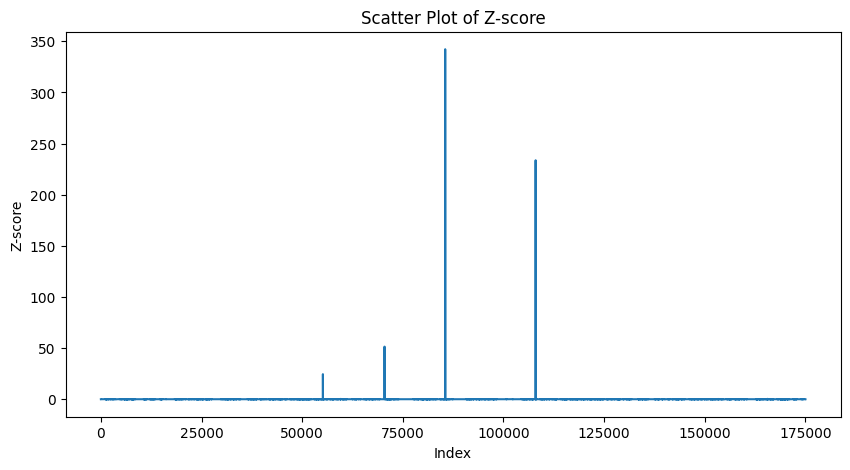

In [23]:
def viz2(train,col_name):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(train[col_name])), train[col_name].sort_values())
    plt.title('Scatter Plot of '+col_name)
    plt.xlabel('Index')
    plt.ylabel(col_name)
    plt.show()

    # Histogram
    plt.figure(figsize=(10, 5))
    plt.hist(train[col_name], bins=30)
    plt.title('Histogram of '+col_name)
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.show()

    # z-score plot
    from scipy import stats
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train[col_name])), stats.zscore(train[col_name]))
    plt.title('Scatter Plot of Z-score')
    plt.xlabel('Index')
    plt.ylabel('Z-score')
    plt.show()

viz2(train,'trip_distance')

We can that values above 20000 seem to be the outliers. We will remove them.

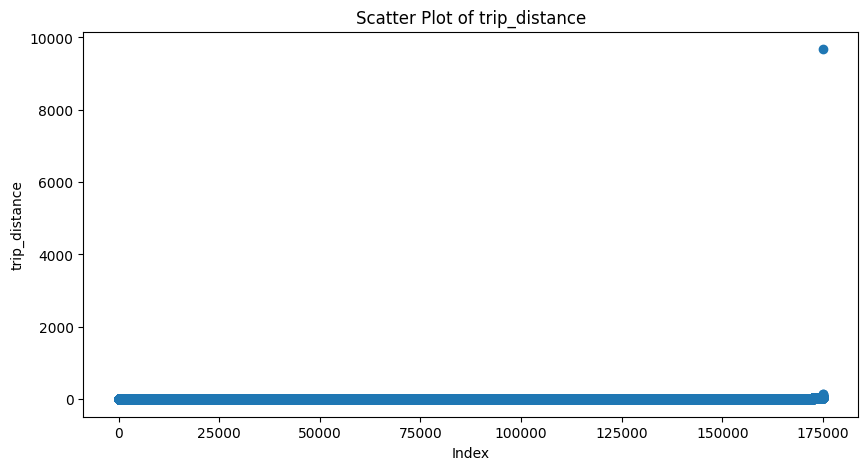

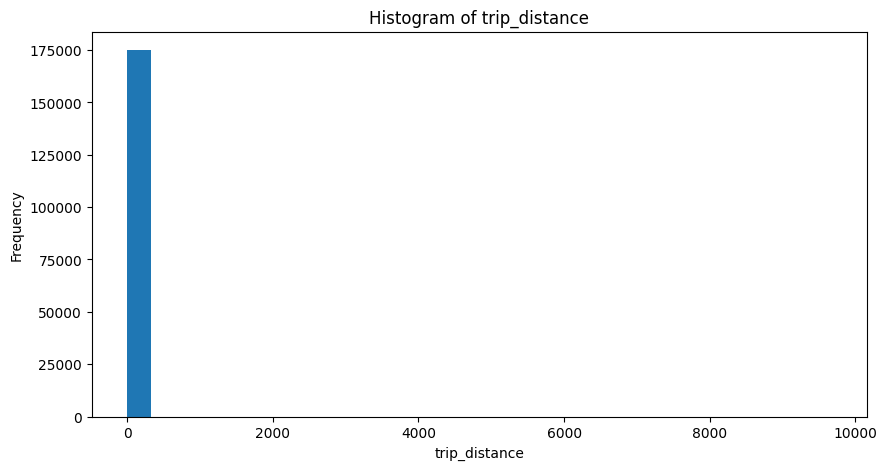

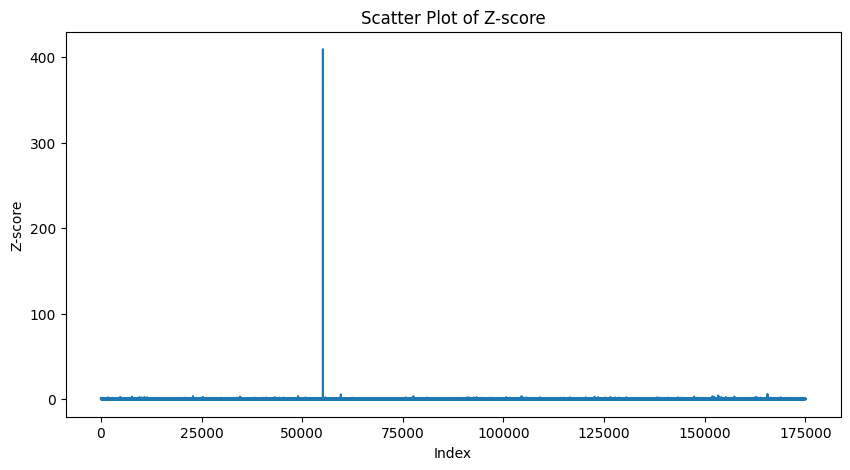

In [24]:
train.drop(train[train['trip_distance'] > 20000].index, inplace=True)
viz2(train,'trip_distance')

Now we can realize that it was not 20000 but 2000!

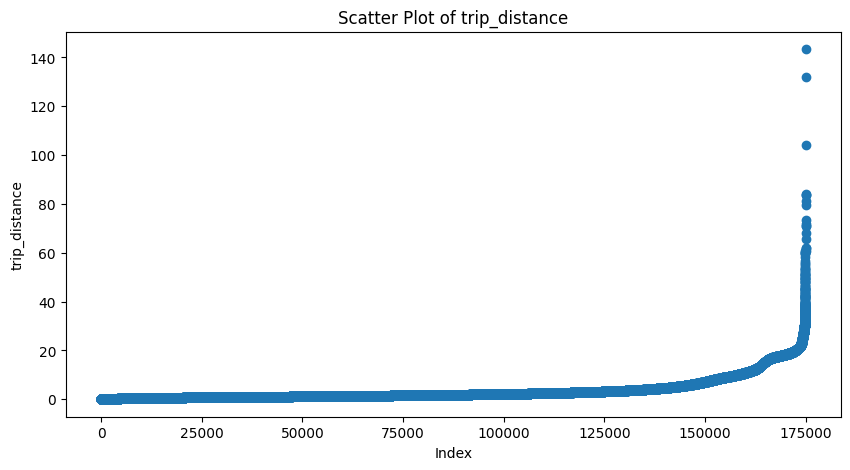

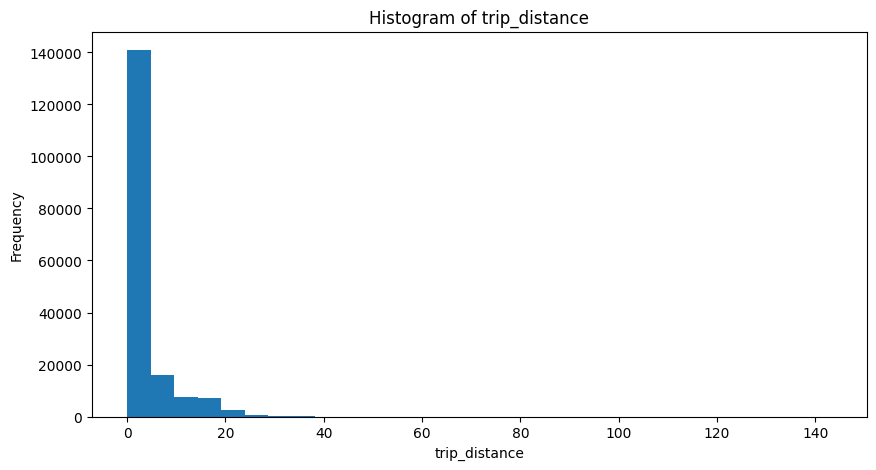

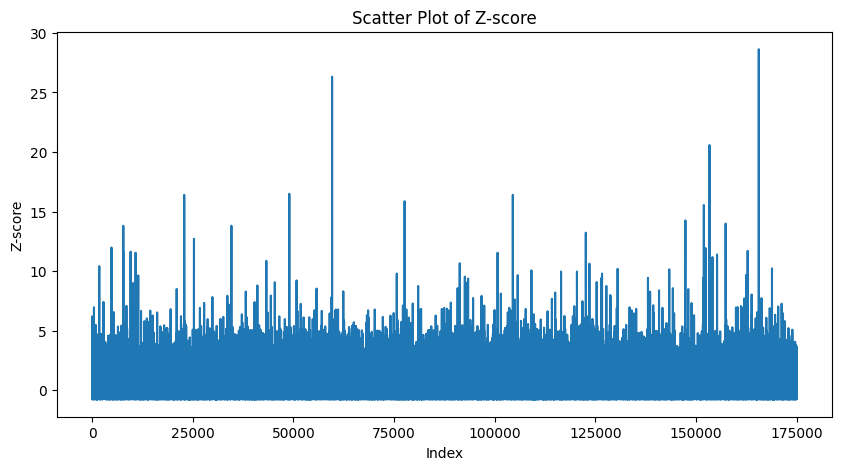

In [25]:
train.drop(train[train['trip_distance'] > 2000].index, inplace=True)
viz2(train,'trip_distance')

In [26]:
def boxplotz(train,col_name):
    plt.boxplot(train[col_name])
    plt.show()
    print(train[col_name].value_counts())

Now it still looks like there are many outliers but we will not remove them as the z-score plot is not as bad as before. 

Now to RatecodeID.

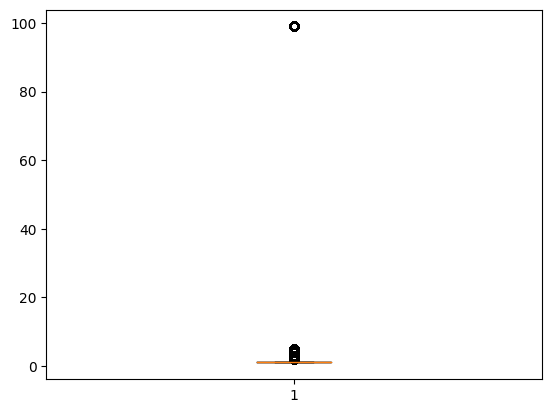

RatecodeID
1.0     164725
2.0       7314
5.0       1033
99.0       748
3.0        727
4.0        446
Name: count, dtype: int64


In [27]:
boxplotz(train,'RatecodeID')

We can see that the it is an ID and all values are significant enough not not be dropped. However I will replace 99 with 6 to prevent bad visualizations or some unexpected odd behavious in the models.

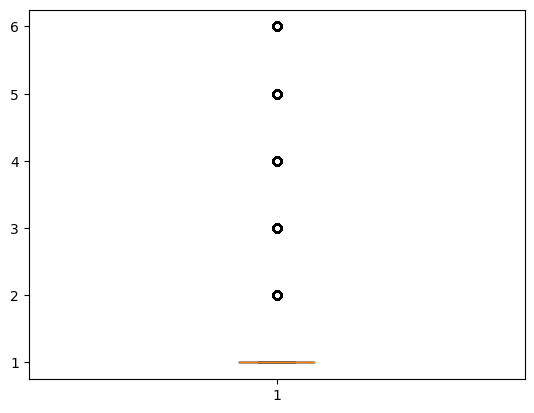

RatecodeID
1.0    164725
2.0      7314
5.0      1033
6.0       748
3.0       727
4.0       446
Name: count, dtype: int64


In [28]:
train['RatecodeID'].replace(99.0, 6.0, inplace=True)
boxplotz(train,'RatecodeID')

Now onto extra

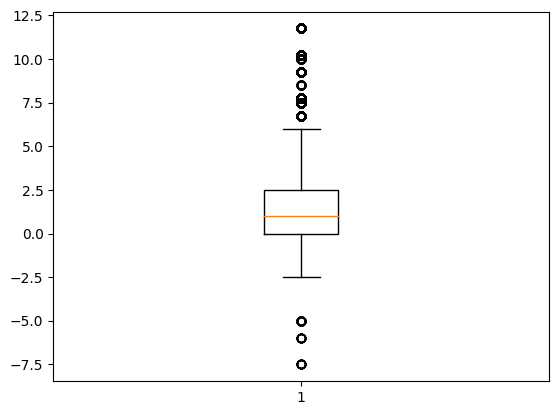

extra
 0.00     51240
 2.50     50180
 1.00     35614
 5.00     17280
 3.50     11839
 7.50      2351
 6.00      1774
 4.25       871
 9.25       812
-1.00       514
-2.50       472
 1.75       413
 2.75       375
 6.75       284
 11.75      258
 10.25      231
 7.75       199
 10.00       96
-5.00        76
 8.50        56
-7.50        22
-6.00        21
 5.25         8
 0.75         2
 3.25         2
 0.25         1
 0.11         1
 1.50         1
Name: count, dtype: int64


In [29]:
boxplotz(train,'extra')

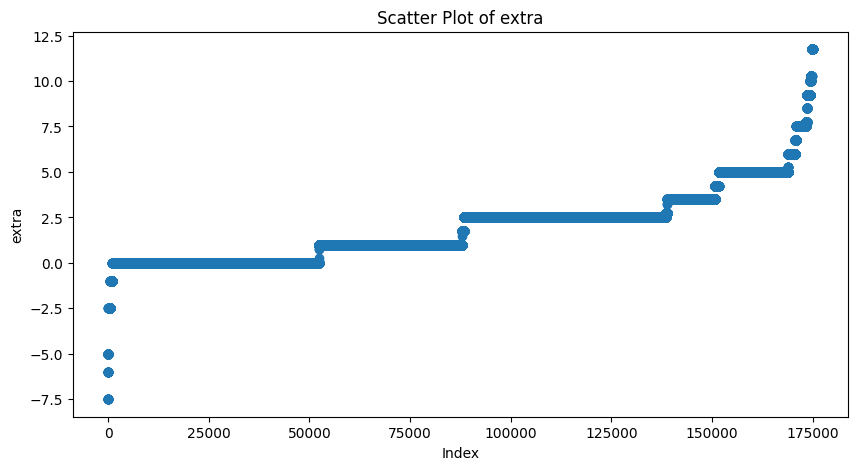

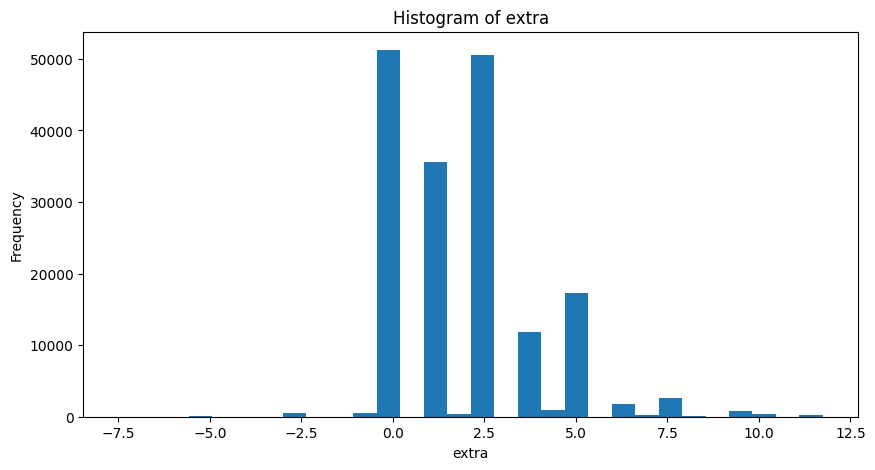

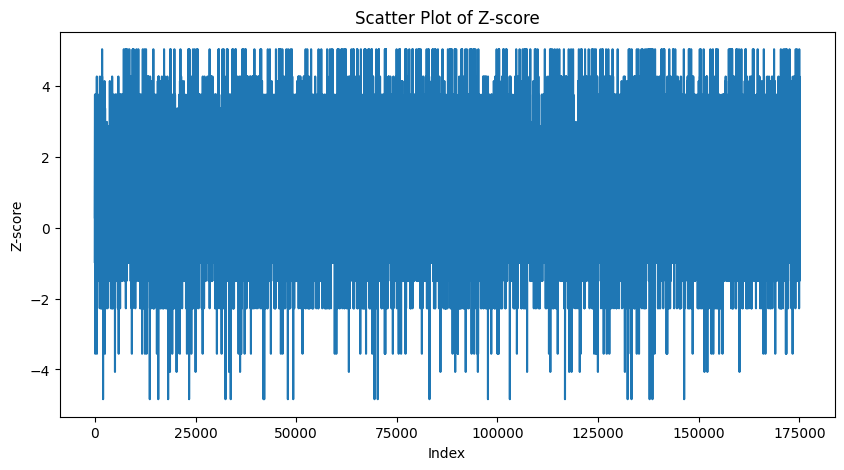

In [30]:
viz2(train,'extra')

We can see that extra is fairly well distributed, so we will not remove any outliers. Now onto tip_amount.

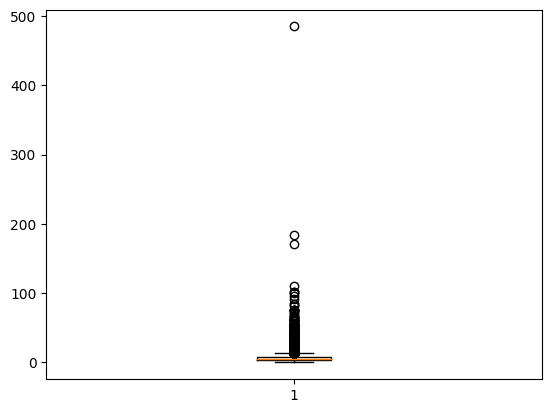

tip_amount
7.165589     1
2.843586     1
9.358723     1
8.530992     1
3.709534     1
            ..
11.560123    1
3.256321     1
6.093614     1
1.099215     1
6.541699     1
Name: count, Length: 174993, dtype: int64


In [31]:
boxplotz(train,'tip_amount')

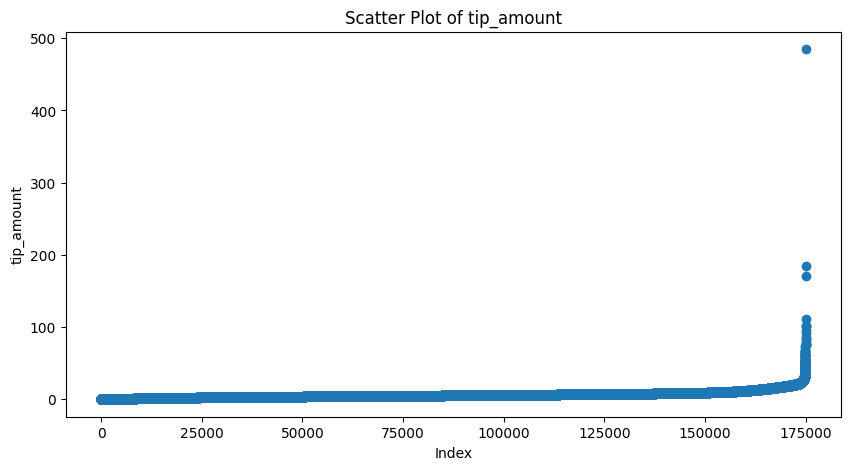

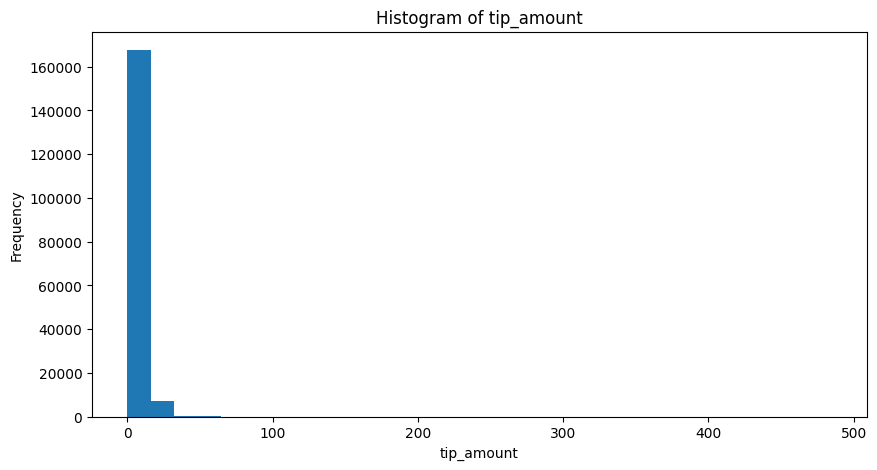

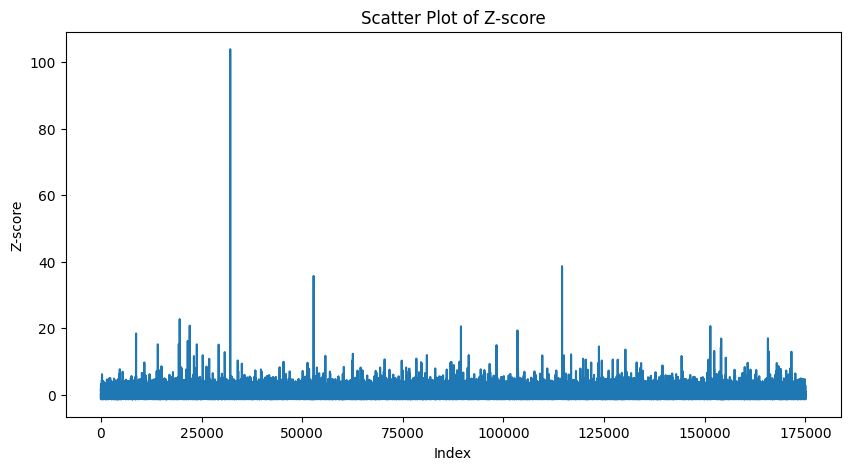

In [32]:
viz2(train,'tip_amount')

We can see that above 100 seems to be the outliers. We will remove them.

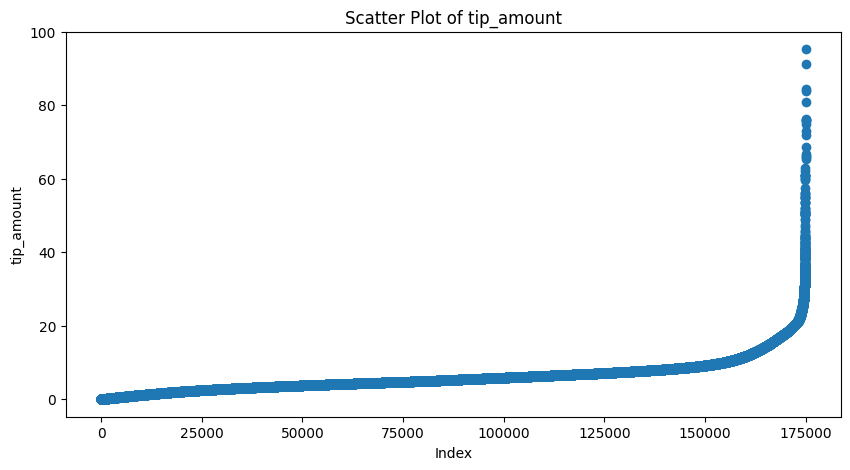

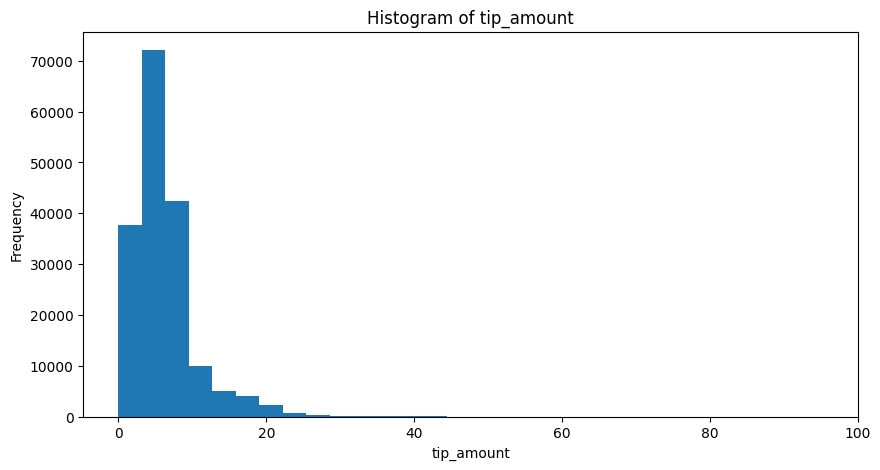

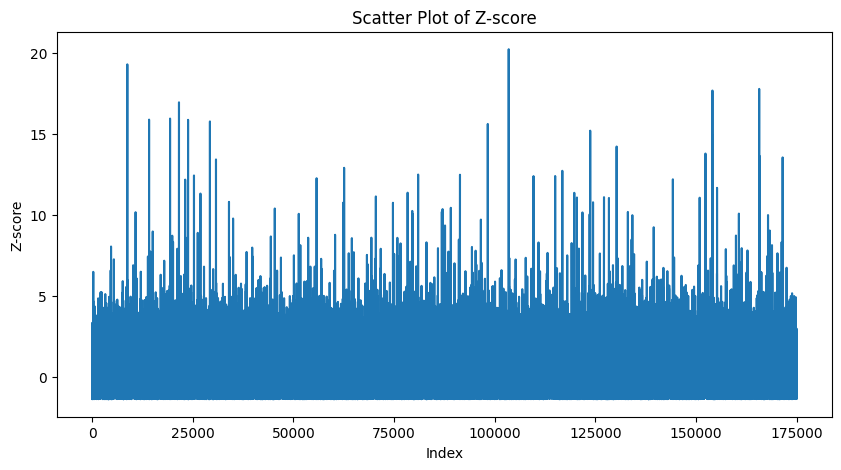

In [33]:
train.drop(train[train['tip_amount'] > 100].index, inplace=True)
viz2(train,'tip_amount')

Now the graphs look better. While the z-score is not ideal going further than 3, we would remove too much. Now onto tolls_amount.

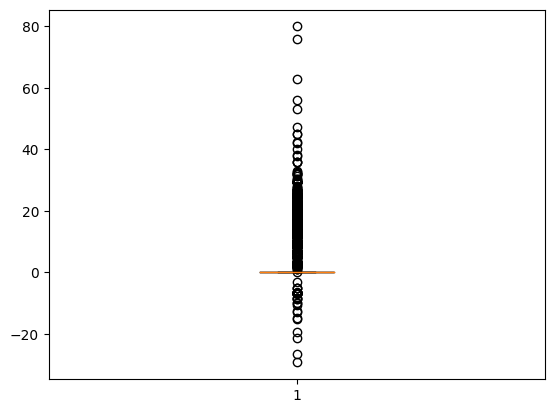

tolls_amount
0.00     159315
6.55      14011
12.75       254
14.75       209
3.00        132
          ...  
63.00         1
18.64         1
15.10         1
20.50         1
14.99         1
Name: count, Length: 214, dtype: int64


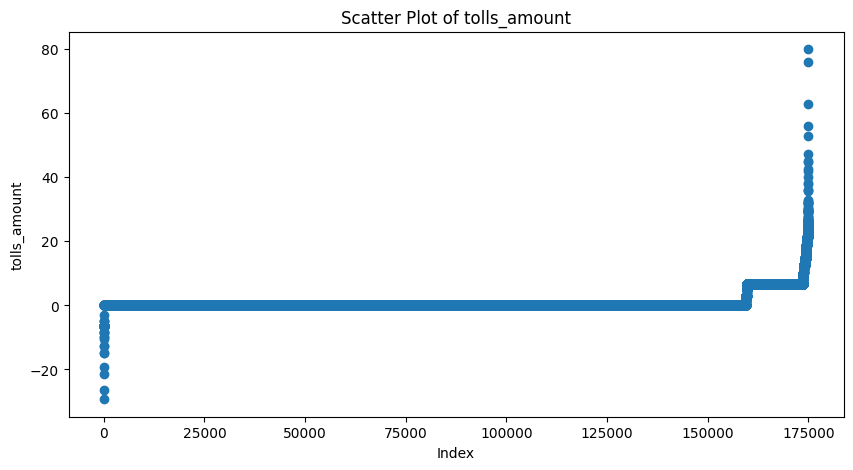

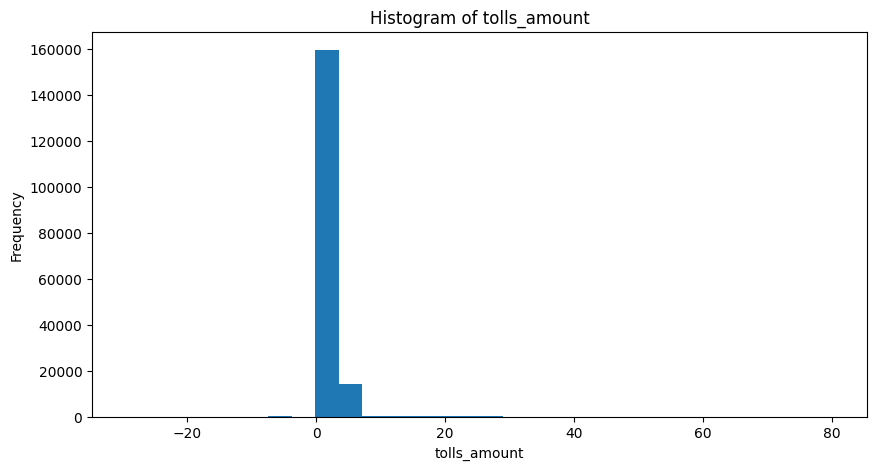

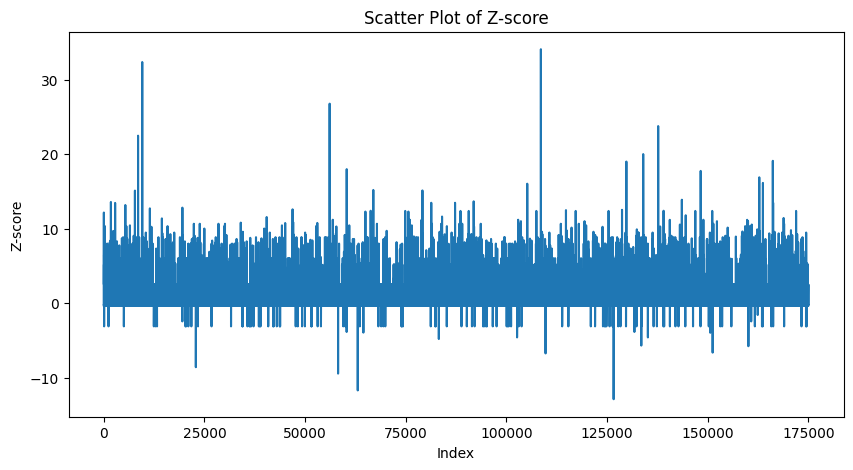

In [34]:
boxplotz(train,'tolls_amount')
viz2(train,'tolls_amount')

We can see that below -5 and above 20 are outliers. We will remove them.

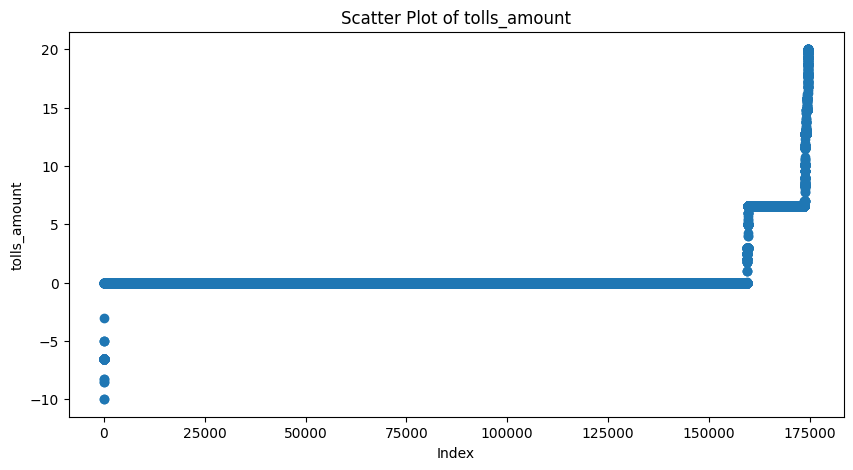

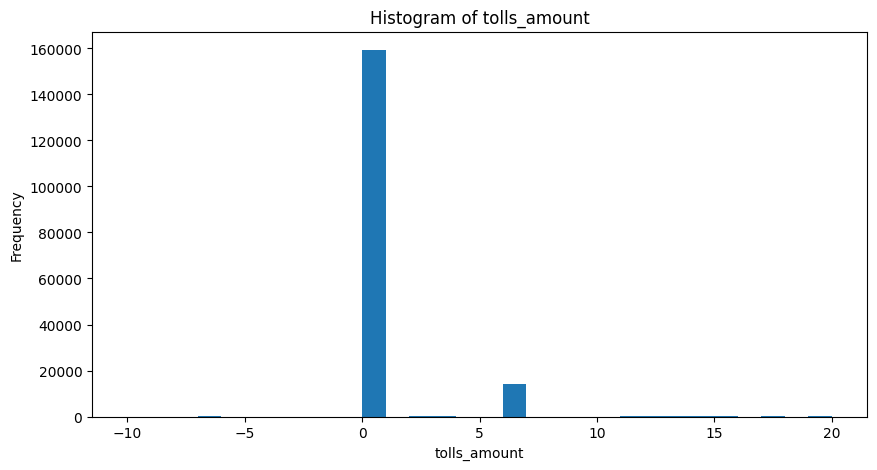

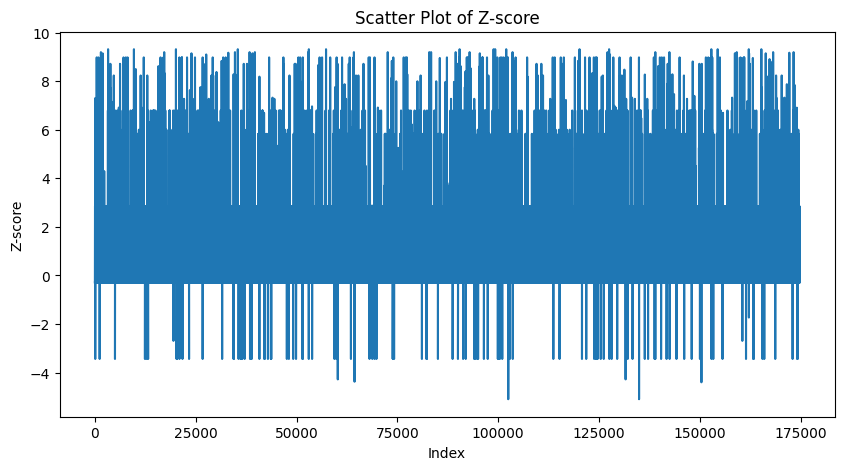

In [35]:
train.drop(train[train['tolls_amount'] > 20].index, inplace=True)
train.drop(train[train['tolls_amount'] < -10].index, inplace=True)
viz2(train,'tolls_amount')

This looks better. Now onto improvement_surcharge.

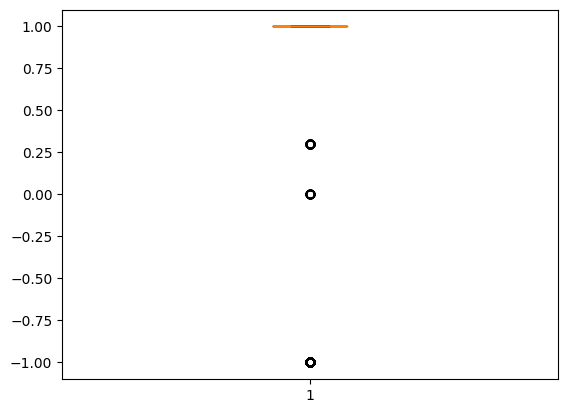

improvement_surcharge
 1.0    172828
-1.0      1716
 0.3        85
 0.0        45
Name: count, dtype: int64


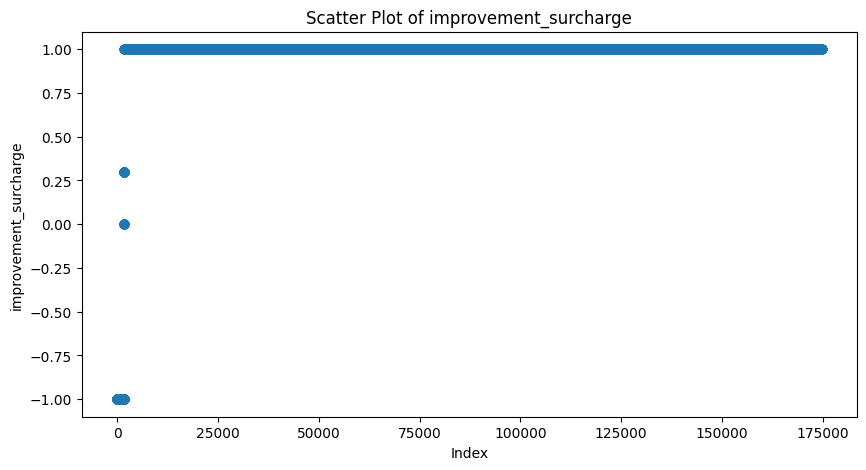

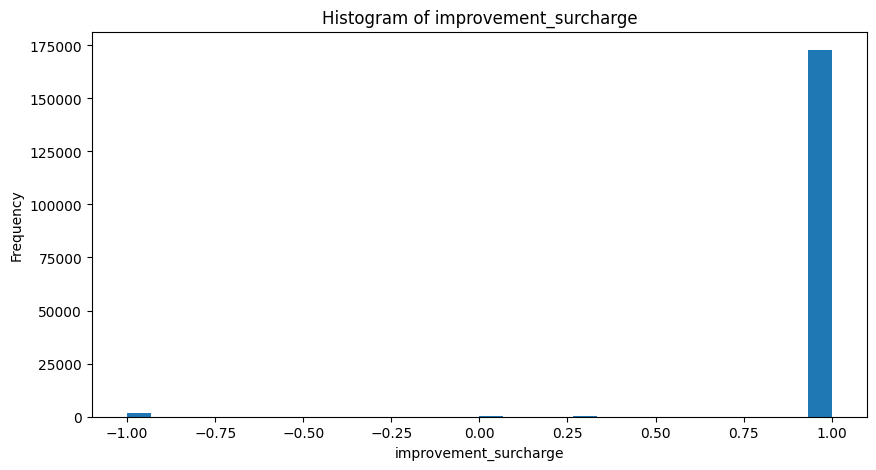

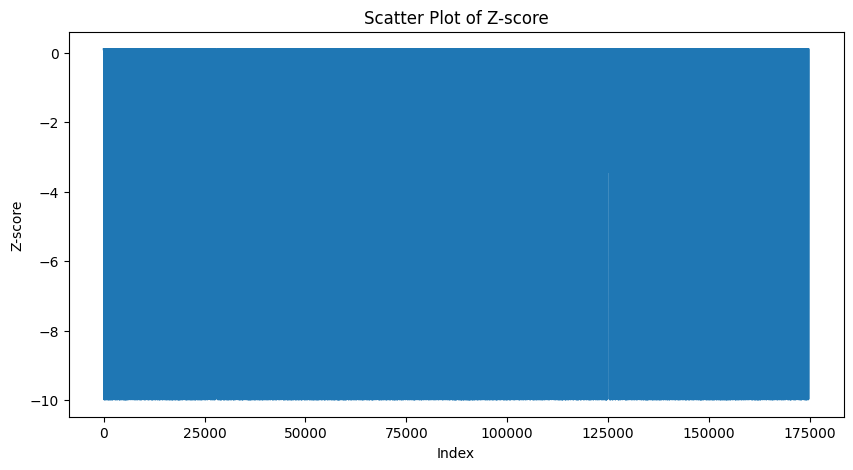

In [36]:
boxplotz(train,'improvement_surcharge')
viz2(train,'improvement_surcharge')

Now we see all the graphs are very "extreme" to look at. If we instead look at the count we can see the range is between -1 and 1. While the number of non 1 entries are low we cannot remove them as it will make it into a static column. Moving on to total_amount.

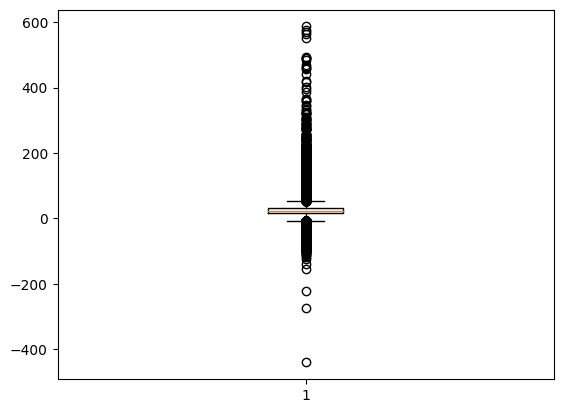

total_amount
16.80     1787
12.60     1648
18.00     1514
21.00     1490
19.80     1260
          ... 
110.99       1
33.68        1
69.57        1
21.68        1
57.43        1
Name: count, Length: 7966, dtype: int64


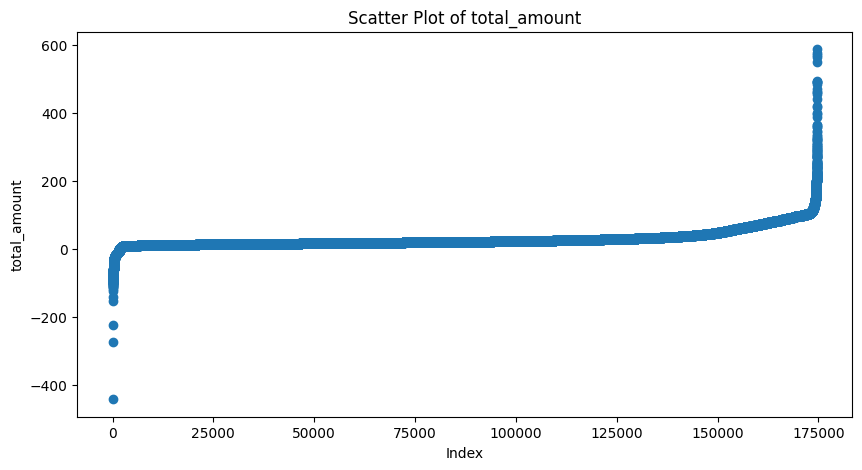

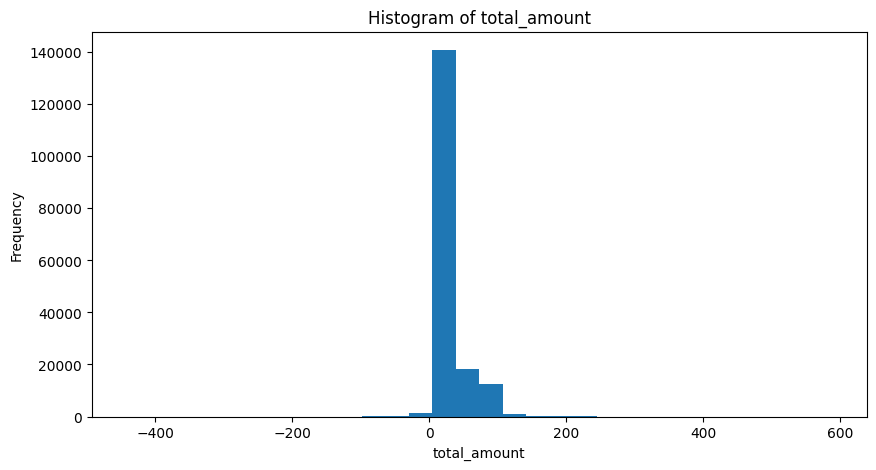

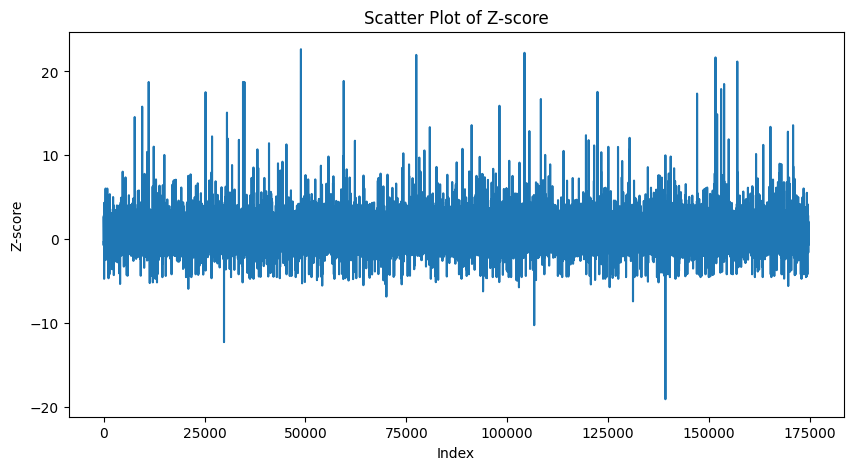

In [37]:
boxplotz(train,'total_amount')
viz2(train,'total_amount')

We can see that there a only a few outliers. Let's remove value below -200 and above 400.

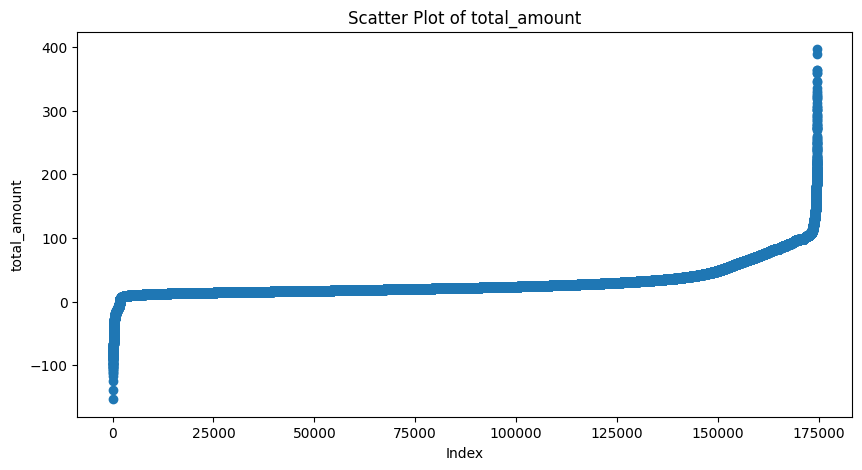

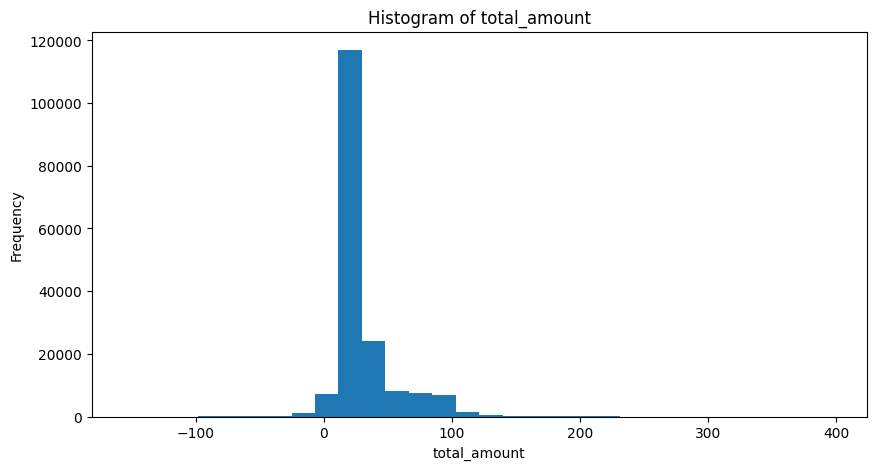

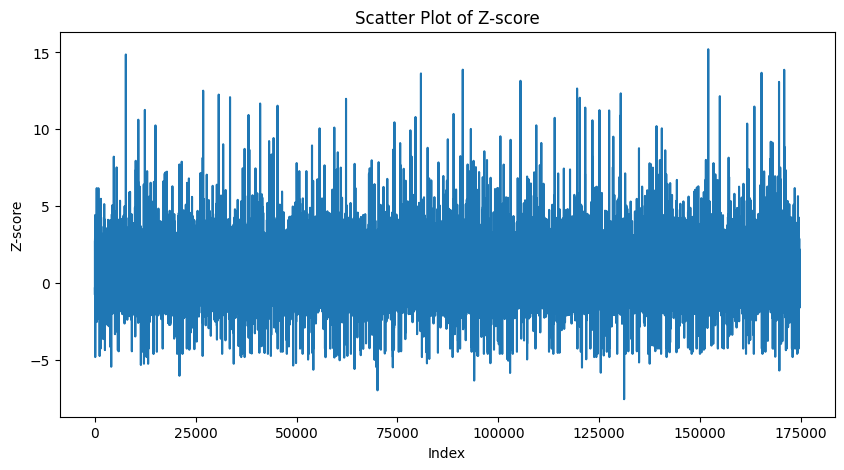

In [38]:
train.drop(train[train['total_amount'] > 400].index, inplace=True)
train.drop(train[train['total_amount'] < -200].index, inplace=True)
viz2(train,'total_amount')

This removes only a few values but overall I won't remove more as it will start removing too many values. Now onto congestion_surcharge.

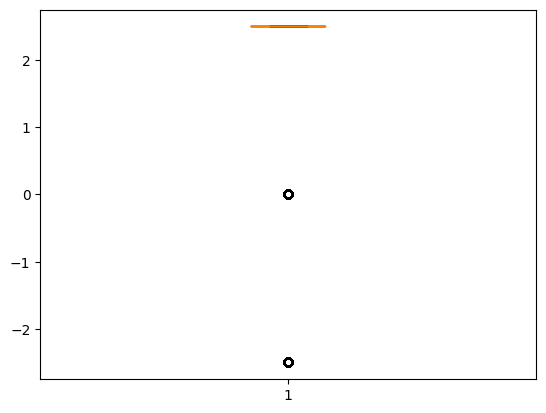

congestion_surcharge
 2.5    159251
 0.0     14018
-2.5      1384
Name: count, dtype: int64


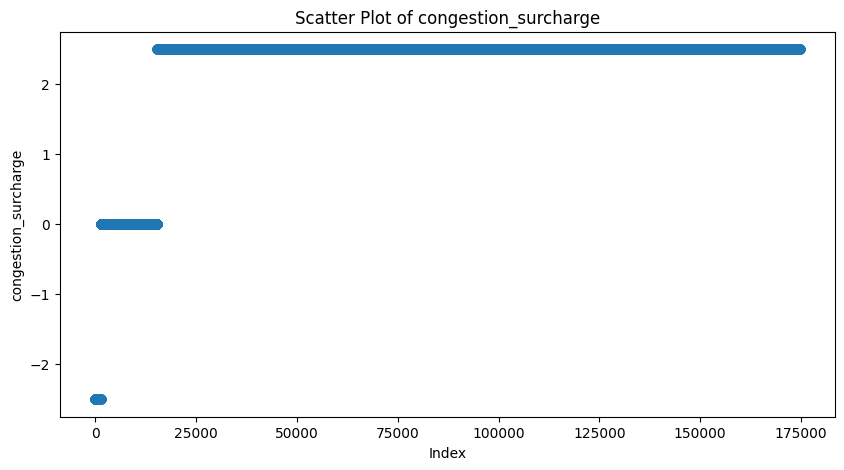

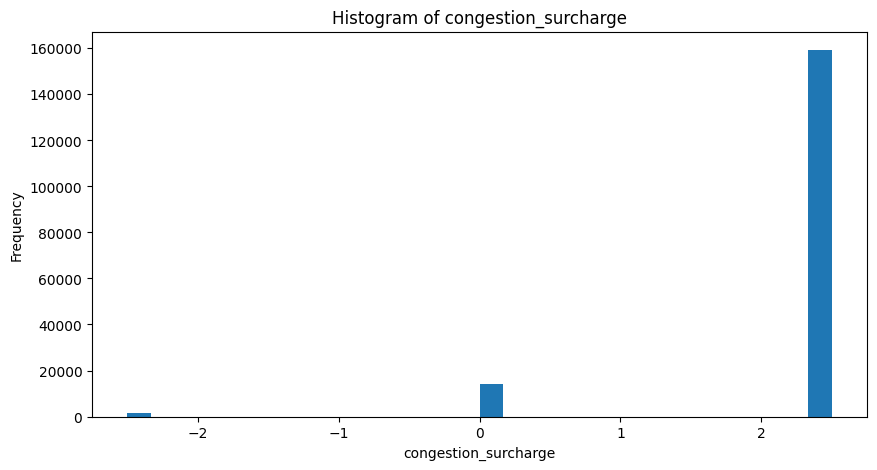

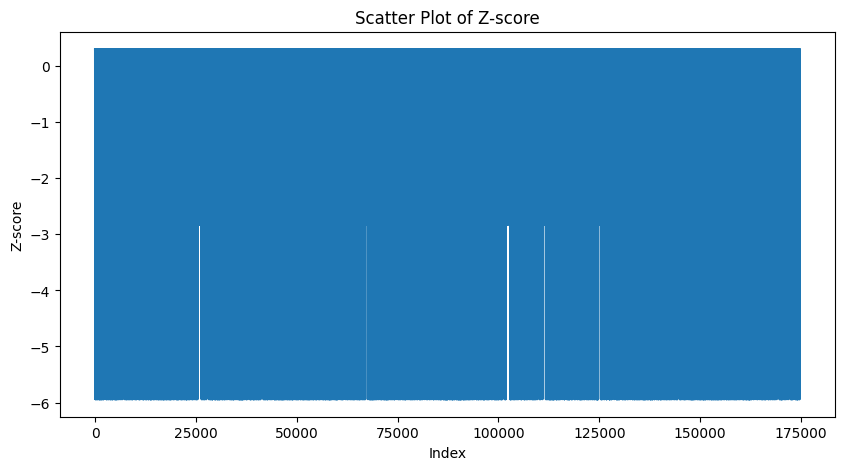

In [39]:
boxplotz(train,'congestion_surcharge')
viz2(train,'congestion_surcharge')

We can see that congestion_surcharge is filled with only 3 values. Removeing any will risk losing valueable data, so we will not remove any. This is the end of data cleaning.

Let's see number of rows between the original and the cleaned data.

In [40]:
print("Original shape of train: ", train_og.shape)
print("Shape of train after cleaning: ", train.shape)
print("Number of rows removed: ", train_og.shape[0] - train.shape[0])

Original shape of train:  (175000, 17)
Shape of train after cleaning:  (174653, 22)
Number of rows removed:  347


We can see that we have not removing a drastic amount of data.

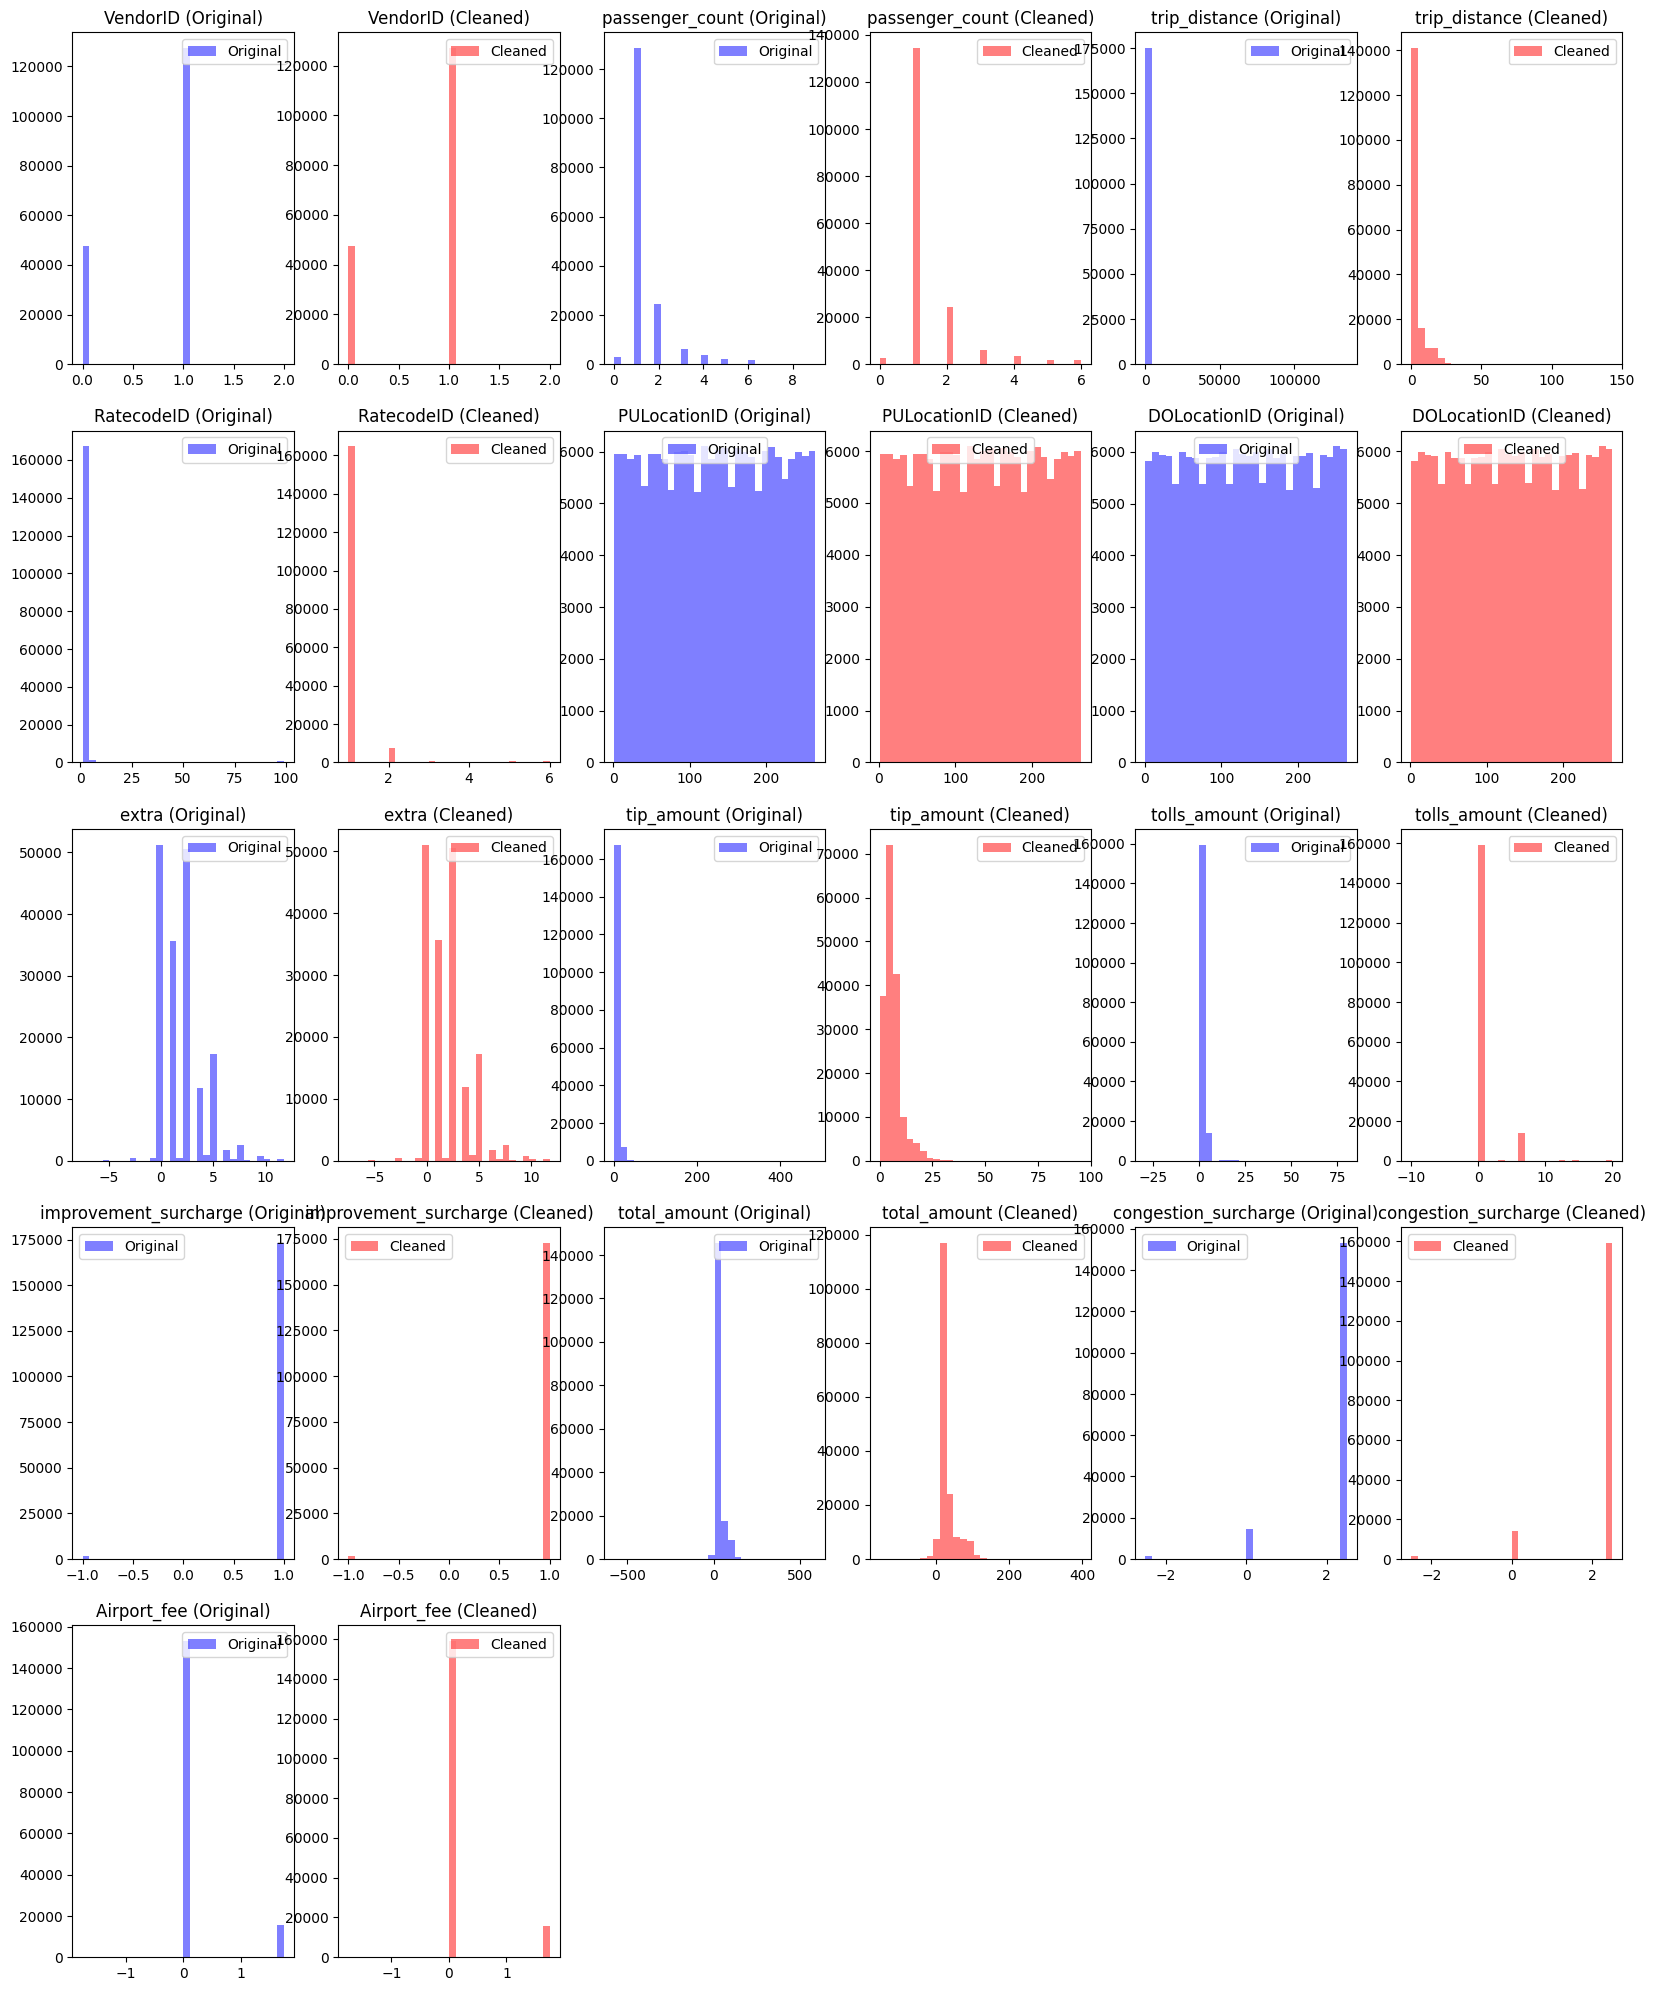

In [41]:
get_vis()

We can see that a few graphs show the improvement after cleaning. While none of them have an ideal distribution, they are better than before.

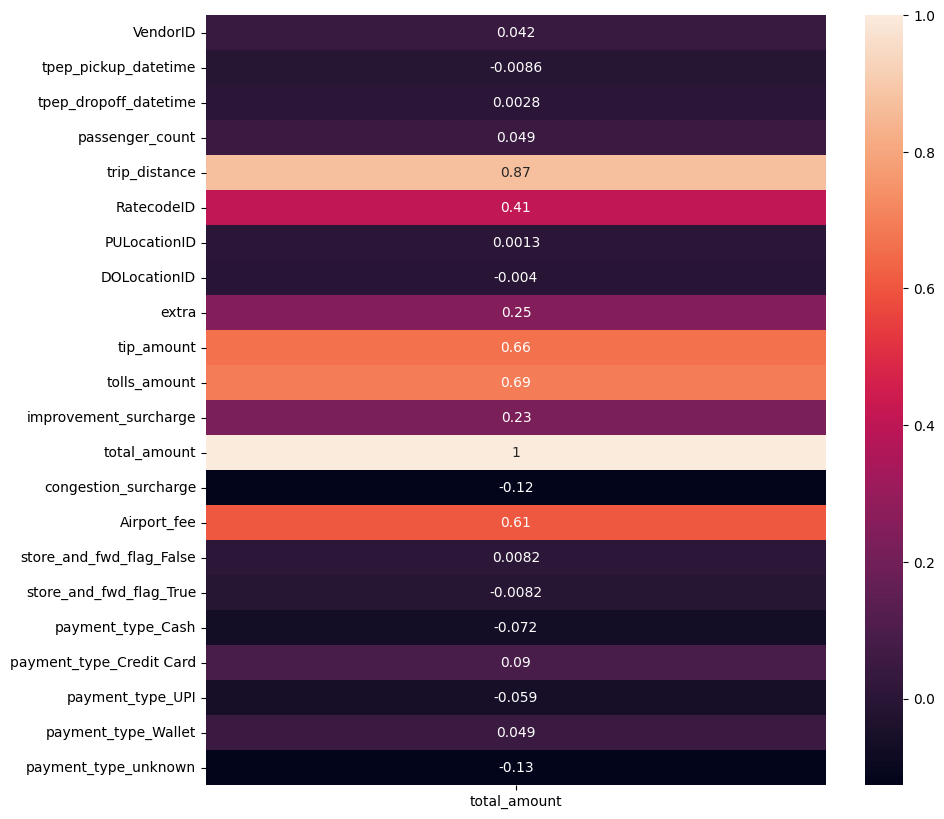

In [42]:
import seaborn as sns
corr = train.corr()[['total_amount']]
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True)
plt.show()

In [43]:
# print column names from corr if the abs value is greater than 0.1
corr_cols = [i for i in corr[abs(corr['total_amount']) > 0.1].index]
for i in corr_cols:
    print(i)

trip_distance
RatecodeID
extra
tip_amount
tolls_amount
improvement_surcharge
total_amount
congestion_surcharge
Airport_fee
payment_type_unknown


These are the columns that the heatmap determined to have correation of over 0.1. We will use these colmns and any related columns.

In [44]:
# print cols not in corr_cols
for i in train.columns:
    if i not in corr_cols:
        print(i)

VendorID
tpep_pickup_datetime
tpep_dropoff_datetime
passenger_count
PULocationID
DOLocationID
store_and_fwd_flag_False
store_and_fwd_flag_True
payment_type_Cash
payment_type_Credit Card
payment_type_UPI
payment_type_Wallet


We will drop all of these. We will also drop payment_type_unknown as well as it also has a fairly low correleation.

In [45]:
# drop columns not in corr_cols
for i in train.columns:
    if i not in corr_cols:
        train.drop(i, axis=1, inplace=True)

train.drop('payment_type_unknown', axis=1, inplace=True)

train.head()

,trip_distance,RatecodeID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2.14,1.0,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,2.70,1.0,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1.15,1.0,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0.40,1.0,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1.10,1.0,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [46]:
train.head()

,trip_distance,RatecodeID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2.14,1.0,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,2.70,1.0,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1.15,1.0,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0.40,1.0,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1.10,1.0,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


These are the columns we will we using. Now we'll make a 80:20 train/test split.

In [47]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(train.drop('total_amount', axis=1), train['total_amount'], test_size=0.2, random_state=42)

# Printing the shapes of the training and testing sets
print("Training data shape: ", train_data.shape)
print("Training labels shape: ", train_labels.shape)
print("Testing data shape: ", test_data.shape)
print("Testing labels shape: ", test_labels.shape)
train_data.head()

Training data shape:  (139722, 8)
Training labels shape:  (139722,)
Testing data shape:  (34931, 8)
Testing labels shape:  (34931,)


,trip_distance,RatecodeID,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee
34585,3.20,1.0,5.0,7.035102,0.0,1.0,2.5,0.0
116400,3.16,1.0,0.0,11.083254,0.0,1.0,2.5,0.0
139616,1.56,1.0,1.0,3.098152,0.0,1.0,2.5,0.0
92237,3.34,1.0,0.0,7.780267,0.0,1.0,2.5,0.0
149758,1.42,1.0,2.5,0.665760,0.0,1.0,2.5,0.0


Creating a pipeline for all this. This is a custom made function that runs a pipeline and then does a few steps after.

In [48]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Define your functions
def fillna_mode(X, columns):
    for column in columns:
        X[column].fillna(X[column].mode()[0], inplace=True)
    return X

def one_hot_encode(X, columns):
    X_encoded = pd.get_dummies(X, columns=columns)
    return X_encoded

def datetime_to_int(X, columns):
    for column in columns:
        X[column] = pd.to_datetime(X[column]).astype('int64') // 10**9
    return X

def bool_to_int(X, columns):
    X[columns] = X[columns].astype(int)
    return X

def drop_corr(X, columns):
    global corr_cols
    for i in X.columns:
        if i not in corr_cols:
            X.drop(i, axis=1, inplace=True)
    X.drop('payment_type_unknown', axis=1, inplace=True)
    return X

def drop_rows(X, conditions):
    for condition in conditions:
        X.drop(X[condition].index, inplace=True)
    return X

def preprocess_data(train_og):
    
    # Create your pipeline
    pipeline = Pipeline([
    ('fillna_mode', FunctionTransformer(fillna_mode, kw_args={'columns': ['store_and_fwd_flag', 'passenger_count', 'RatecodeID', 'congestion_surcharge', 'Airport_fee']})),
    ('one_hot_encode', FunctionTransformer(one_hot_encode, kw_args={'columns': ['store_and_fwd_flag', 'payment_type']})),
    ('datetime_to_int', FunctionTransformer(datetime_to_int, kw_args={'columns': ['tpep_pickup_datetime', 'tpep_dropoff_datetime']})),
    ('bool_to_int', FunctionTransformer(bool_to_int, kw_args={'columns': ['store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'payment_type_Cash', 'payment_type_Credit Card', 'payment_type_UPI', 'payment_type_Wallet', 'payment_type_unknown']})),
    ('drop_corr', FunctionTransformer(drop_corr, kw_args={'columns': []} )),
    ('drop_rows', FunctionTransformer(drop_rows, kw_args={'conditions': [train_og['passenger_count'] > 7, train_og['trip_distance'] > 2000, train_og['tip_amount'] > 100, train_og['tolls_amount'] > 20, train_og['tolls_amount'] < -10, train_og['total_amount'] > 400, train_og['total_amount'] < -200]}))
    ])
    train_pipe = pipeline.fit_transform(train_og)
    train_data, test_data, train_labels, test_labels = train_test_split(
        train_pipe.drop("total_amount", axis=1),
        train_pipe["total_amount"],
        test_size=0.2,
        random_state=42,
    )
    return train_data, test_data, train_labels, test_labels

## Now for the models!
Model 1: KNN
We know KNN is effected by the curse of dimentionality so we will drop a few columns from the data.

###### Linear regression has been deleted as it is not accurate.

In [49]:
train_data_knn, test_data_knn, train_labels_knn, test_labels_knn = preprocess_data(train_og)

C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_140

In [50]:
train_data_knn = train_data_knn[['trip_distance', 'RatecodeID', 'tip_amount', 'tolls_amount', 'Airport_fee']]
test_data_knn = test_data_knn[['trip_distance', 'RatecodeID', 'tip_amount', 'tolls_amount', 'Airport_fee']]

In [51]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(train_data_knn, train_labels)


test_predictions = knn.predict(test_data_knn)
rmse = mean_squared_error(test_labels, test_predictions, squared=False)

print("Model RMSE: ", rmse)

Model RMSE:  8.310004706524778


In [52]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(train_data, train_labels)


test_predictions = knn.predict(test_data)
rmse = mean_squared_error(test_labels, test_predictions, squared=False)

print("Model RMSE: ", rmse)

Model RMSE:  6.076676880090422


We can see that despite the reduction in dimentions, the model is running around the same speed, almost within margin of error. Furthermore the accuracy is worse on the reduced dimentions. We will not the reduced dataset.

Previous runs have shown the best params as:

`Best parameters:  {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}`

So this grid search will be very reduced for demonstration. The original grid search to find the above parameters took over 10 minutes to run.

```python
param_grid = {
    'n_neighbors': [1, 3, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'leaf_size': [1, 2],
    'p': [1],
    'n_jobs': [-1]
}
```

This param grid is likely what I had run initial tests on. I have lost the original grid.

In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors' : np.arange(3, 4),
    'weights': ['uniform'],
    'algorithm': ['auto'],
    'leaf_size': [1],
    'p' : [1],
    'n_jobs': [-1]
}

knn = KNeighborsRegressor()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(train_data, train_labels)

best_params = knn_cv.best_params_
print("Best parameters: ", best_params)

best_score = knn_cv.best_score_
print("Best score: ", best_score)

Best parameters:  {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best score:  0.9358764194236308


In [54]:
model = knn_cv.best_estimator_
model.fit(train_data, train_labels)

KNeighborsRegressor(leaf_size=1, n_jobs=-1, n_neighbors=3, p=1)

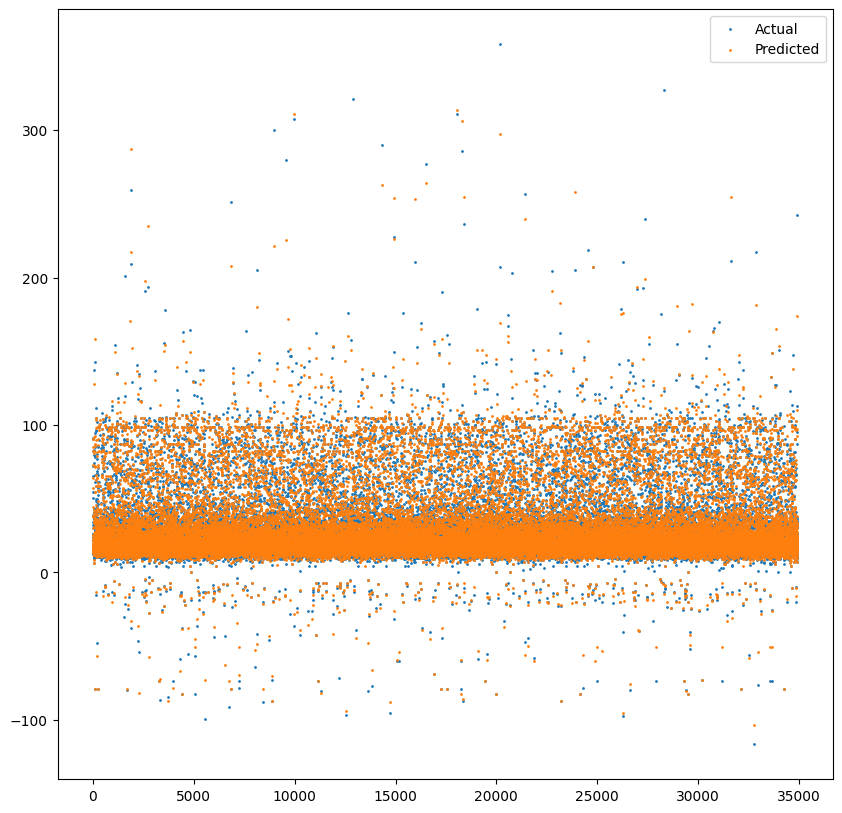

In [55]:
predictions = model.predict(test_data)
plt.figure(figsize=(10,10))
plt.scatter(range(len(test_labels)), test_labels, label='Actual', s=1)
plt.scatter(range(len(test_labels)), predictions, label='Predicted', s=1)
plt.legend()
plt.show()

We can see that the KNN is fairly accurate. The more Orage and the less blue in these graphs the better.

Tests on SVM gave disappointing results so I an not keeping SVM. It also takes too long to run.


Model 2: CART

In [56]:
train_data_cart, test_data_cart, train_labels_cart, test_labels_cart = preprocess_data(train_og)

C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_140

In [57]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

clf = DecisionTreeRegressor(random_state=42)
clf.fit(train_data_cart, train_labels_cart)

test_predictions = clf.predict(test_data_cart)
rmse = mean_squared_error(test_labels_cart, test_predictions, squared=False)

print("Model RMSE: ", rmse)

Model RMSE:  7.225430603423156


This is a basic decision tree. GridSearchCV is kept intact as it is quick to run.

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['squared_error','friedman_mse'],
    'max_depth': [1, 15, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

clf = DecisionTreeRegressor(random_state=42)
clf_cv = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
clf_cv.fit(train_data_cart, train_labels_cart)

print("Best param:", clf_cv.best_params_)
print("Best score:", clf_cv.best_score_)

Best param: {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 2}
Best score: 0.9392481684001399


In [59]:
model = clf_cv.best_estimator_
model.fit(train_data_cart, train_labels_cart)
test_predictions = model.predict(test_data_cart)
rmse = mean_squared_error(test_labels_cart, test_predictions, squared=False)
print("Model RMSE: ", rmse)

Model RMSE:  6.14984487499453


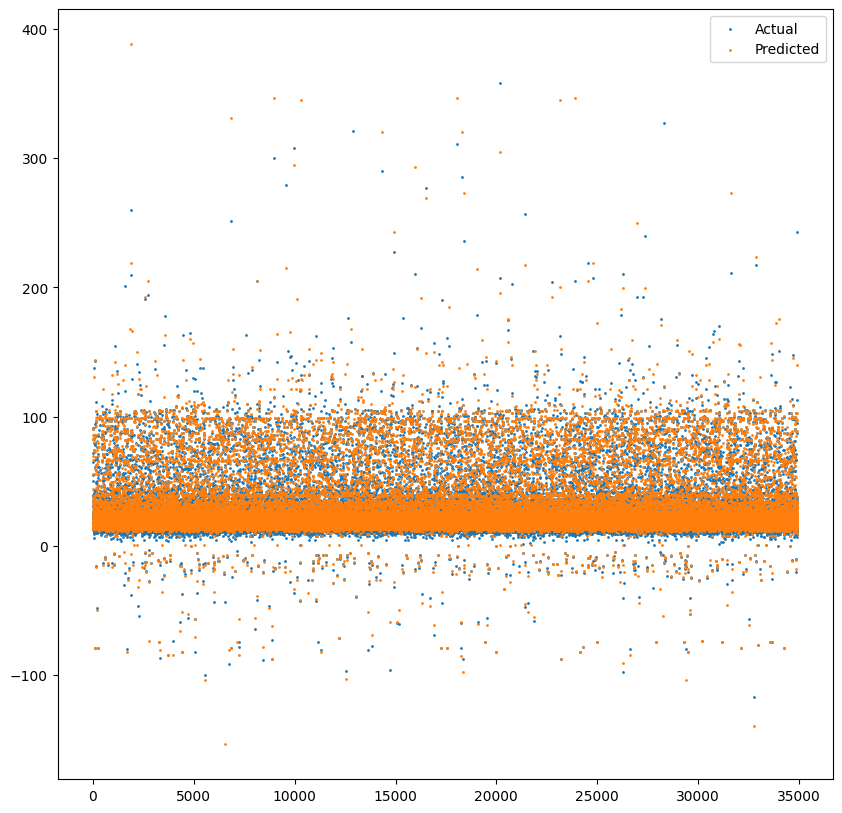

In [60]:
predictions = model.predict(test_data)
plt.figure(figsize=(10,10))
plt.scatter(range(len(test_labels)), test_labels, label='Actual', s=1)
plt.scatter(range(len(test_labels)), predictions, label='Predicted', s=1)
plt.legend()
plt.show()

Not as much orange! This has worked surprisingly well! Now I will trying bagging and boosting. I will carry over the Descision Tree parameters.

In [61]:
train_data_bgbt, test_data_bgbt, train_labels_bgbt, test_labels_bgbt = preprocess_data(train_og)

C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_140

In [62]:
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor

bag_reg = BaggingRegressor(
    clf_cv.best_estimator_,
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    random_state=42,
)
bag_reg.fit(train_data_bgbt, train_labels_bgbt)
bag_pred = bag_reg.predict(test_data_bgbt)
bag_rmse = mean_squared_error(test_labels_bgbt, bag_pred, squared=False)

print("Bagging Regressor RMSE: ", bag_rmse)

Bagging Regressor RMSE:  9.822240816627296


In [63]:
ada_reg = AdaBoostRegressor(
    clf_cv.best_estimator_,
    n_estimators=200,
    learning_rate=0.5,
    random_state=42,
)
ada_reg.fit(train_data_bgbt, train_labels_bgbt)
ada_pred = ada_reg.predict(test_data_bgbt)
ada_rmse = mean_squared_error(test_labels_bgbt, ada_pred, squared=False)

print("AdaBoost Regressor RMSE: ", ada_rmse)

AdaBoost Regressor RMSE:  6.014099826578024


From the basic model, boosting seems to have more potential. Now I will try to tune the parameters.

In [64]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.3, 0.5, 0.7],
    'random_state': [42]
}

ada_grid = GridSearchCV(AdaBoostRegressor(clf_cv.best_estimator_), param_grid, cv=2, n_jobs=-1)

ada_grid.fit(train_data_bgbt, train_labels_bgbt)
print("Best param:", ada_grid.best_params_)
print("Best score:", ada_grid.best_score_)

Best param: {'learning_rate': 0.3, 'n_estimators': 50, 'random_state': 42}
Best score: 0.9482637095229782


In [65]:
model = ada_grid.best_estimator_
model.fit(train_data_bgbt, train_labels_bgbt)
test_predictions = model.predict(test_data_bgbt)
rmse = mean_squared_error(test_labels_bgbt, test_predictions, squared=False)

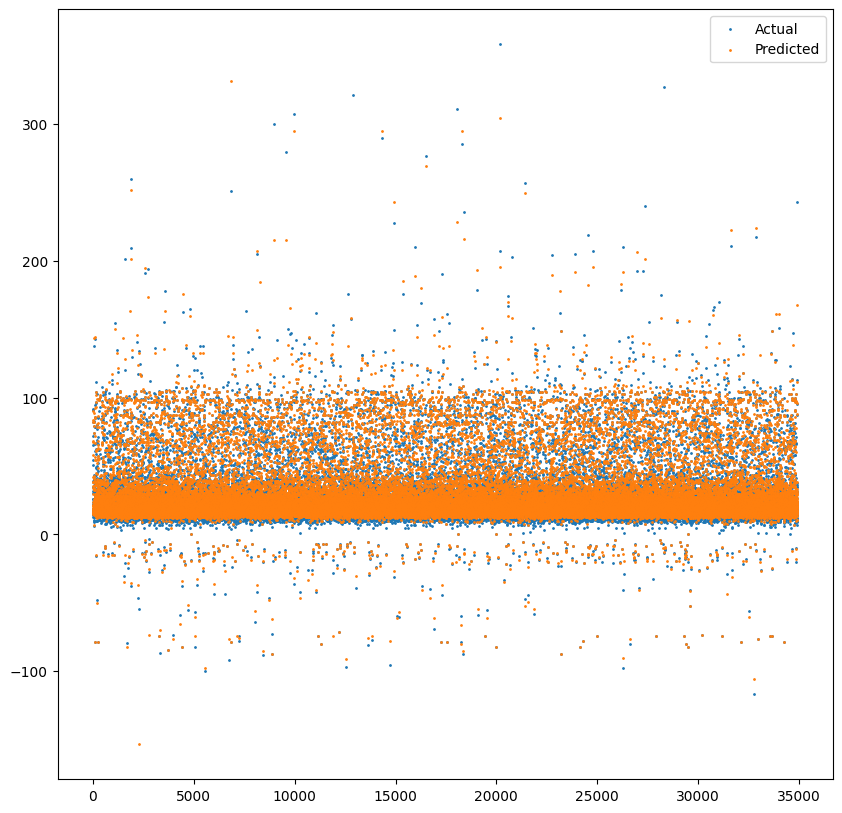

In [66]:
predictions = model.predict(test_data)
plt.figure(figsize=(10,10))
plt.scatter(range(len(test_labels)), test_labels, label='Actual', s=1)
plt.scatter(range(len(test_labels)), predictions, label='Predicted', s=1)
plt.legend()
plt.show()

This is even better! The graph can't really show the difference to be very honest. Now we'll try MLP!

In [67]:
train_data_mlp, test_data_mlp, train_labels_mlp, test_labels_mlp = preprocess_data(train_og)

C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_140

In [68]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

mlp_reg = MLPRegressor(random_state=42, max_iter=100, early_stopping=True, learning_rate='adaptive', learning_rate_init=0.02)
mlp_reg.fit(train_data_mlp, train_labels_mlp)

mlp_pred = mlp_reg.predict(test_data_mlp)
rmse = mean_squared_error(test_labels_mlp, mlp_pred, squared=False)

print("Model RMSE: ", rmse)

Model RMSE:  5.748488975534658


I am commenting out the grid search as it takes too long to run and I am not happy with the results from the previous runs and tests.

In [69]:
# param_grid = {
#     'learning_rate_init': [0.01, 0.02],
#     'learning_rate': ['adaptive'],
#     'activation': ['relu', 'tanh']
# }

# grid_mlp = GridSearchCV(MLPRegressor(random_state=42, max_iter=100, early_stopping=True), param_grid, cv=2, n_jobs=-1)

# grid_mlp.fit(train_data_mlp, train_labels_mlp)
# print("Best param:", grid_mlp.best_params_)
# print("Best score:", grid_mlp.best_score_)

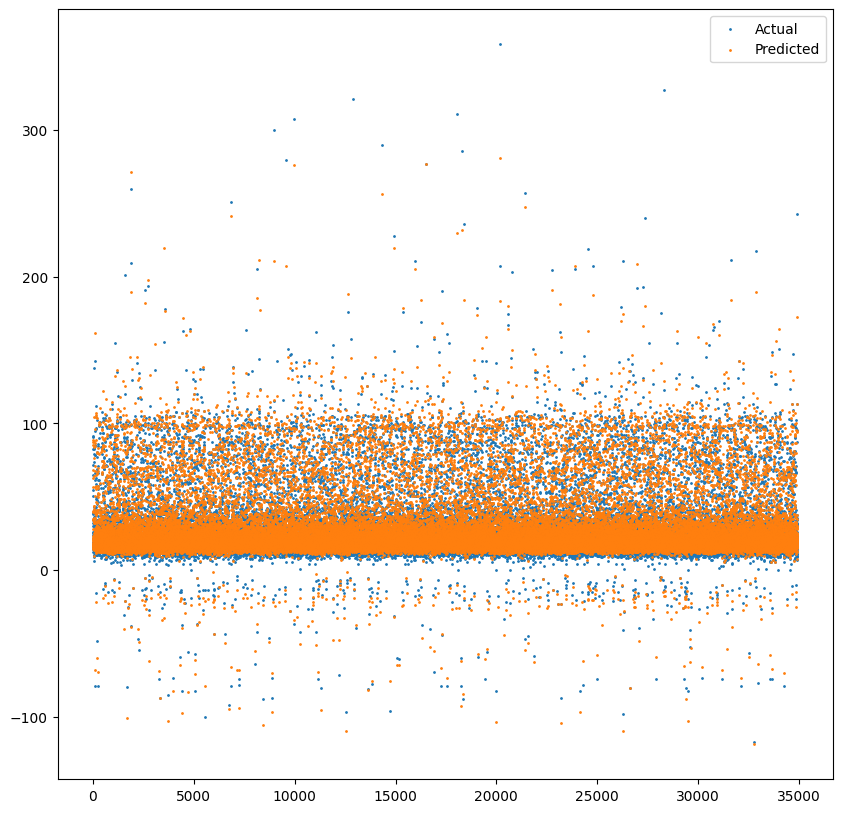

In [70]:
predictions = mlp_reg.predict(test_data)
plt.figure(figsize=(10,10))
plt.scatter(range(len(test_labels)), test_labels, label='Actual', s=1)
plt.scatter(range(len(test_labels)), predictions, label='Predicted', s=1)
plt.legend()
plt.show()

MLP had a conparitively terrible score! It also took very long to run. I will not attempt to refine it further. Let's try random forest!

In [71]:
train_data_randf, test_data_randf, train_labels_randf, test_labels_randf = preprocess_data(train_og)

C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_14028\2646668206.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[condition].index, inplace=True)
C:\Users\Anirudha\AppData\Local\Temp\ipykernel_140

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1)

rf_reg.fit(train_data_randf, train_labels_randf)
rf_pred = rf_reg.predict(test_data_randf)

rmse = mean_squared_error(test_labels_randf, rf_pred, squared=False)
print("Random Forest RMSE: ", rmse)

Random Forest RMSE:  5.579489960474481


This is my main model for the predictions. I have used this 
```python
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [10, 20],
    'bootstrap': [True],
    'random_state': [42],
    'n_jobs': [-1],
    'oob_score': [True, False]
}
```
in the past and I have saved the resulting parameters. I will use them here.

In [73]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'bootstrap': [True],
    'random_state': [42],
    'n_jobs': [-1],
    'oob_score': [True]
}

grid_ranf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, n_jobs=-1)

grid_ranf.fit(train_data_randf, train_labels_randf)
print("Best param:", grid_ranf.best_params_)
print("Best score:", grid_ranf.best_score_)

Best param: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best score: 0.9508765074880872


In [74]:
model = grid_ranf.best_estimator_
model.fit(train_data_bgbt, train_labels_bgbt)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=42)

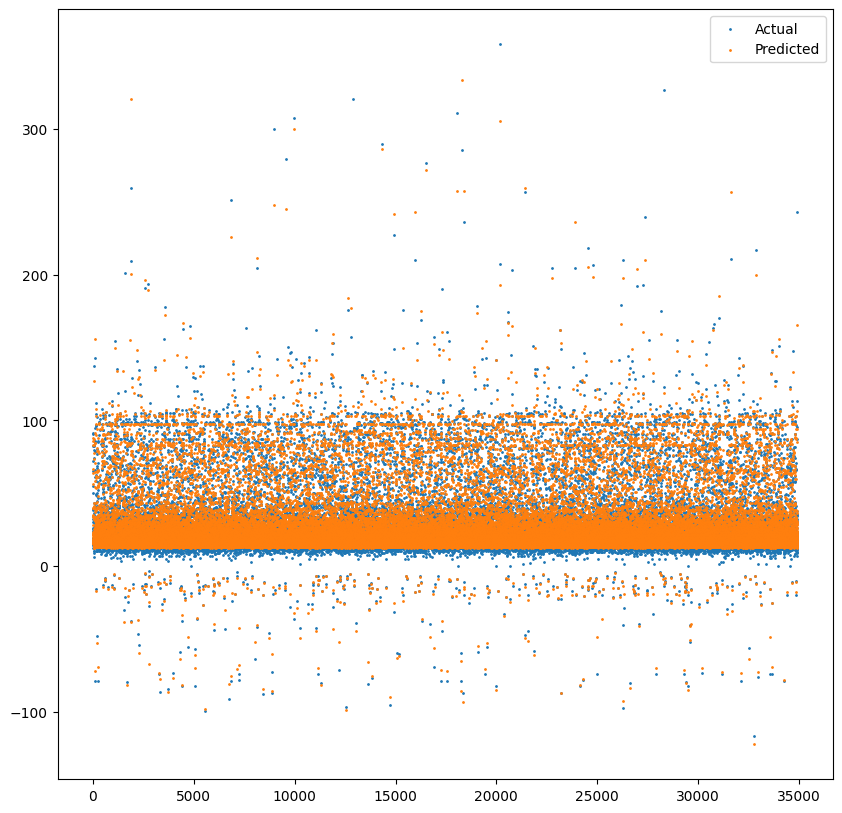

In [75]:
predictions = model.predict(test_data)
#set size of plot to be large
plt.figure(figsize=(10,10))
plt.scatter(range(len(test_labels)), test_labels, label='Actual', s=1)
plt.scatter(range(len(test_labels)), predictions, label='Predicted', s=1)
plt.legend()
plt.show()

Now that the model is set, let's check the test data and prepare to make `submission.csv`.

In [76]:
test.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee
0,1,2023-06-29 00:21:20,2023-06-29 00:25:20,1.0,4.95,1.0,N,20,3,Credit Card,1.0,6.067612,0.0,1.0,2.5,0.0
1,1,2023-06-30 17:44:43,2023-06-30 17:53:13,1.0,2.10,1.0,N,9,81,Credit Card,2.5,6.191269,0.0,1.0,2.5,0.0
2,1,2023-06-29 18:17:04,2023-06-29 19:23:48,1.0,0.95,1.0,N,92,90,Cash,2.5,3.983872,0.0,1.0,2.5,0.0
3,0,2023-06-30 21:33:53,2023-06-30 21:46:20,1.0,0.80,1.0,N,19,102,Credit Card,3.5,6.839341,0.0,1.0,2.5,0.0
4,1,2023-06-29 14:53:54,2023-06-29 15:22:17,1.0,4.01,1.0,N,131,229,Cash,0.0,1.468943,0.0,1.0,0.0,0.0


In [77]:
test = test[train.drop('total_amount', axis=1).columns]
test.head()

,trip_distance,RatecodeID,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee
0,4.95,1.0,1.0,6.067612,0.0,1.0,2.5,0.0
1,2.10,1.0,2.5,6.191269,0.0,1.0,2.5,0.0
2,0.95,1.0,2.5,3.983872,0.0,1.0,2.5,0.0
3,0.80,1.0,3.5,6.839341,0.0,1.0,2.5,0.0
4,4.01,1.0,0.0,1.468943,0.0,1.0,0.0,0.0


In [78]:
test['RatecodeID'].fillna(test['RatecodeID'].mode()[0], inplace=True)
test['congestion_surcharge'].fillna(test['congestion_surcharge'].mode()[0], inplace=True)
test['Airport_fee'].fillna(test['Airport_fee'].mode()[0], inplace=True)

In [79]:
predictions = model.predict(test)
predictions.shape
predictions.shape[0]+1
sub_df = pd.DataFrame({
    'ID': range(1, len(predictions) + 1),
    'total_amount': predictions
})
sub_df.head()
sub_df.to_csv('submission.csv', index=False)

In [80]:
# import xgboost as xgb
# import imblearn as imb
# import pickle as pkl
# import regex as re
# import seaborn as sns
# import lightgbm as lgb